In [1]:
# import useful libraries
from collections import Counter, defaultdict
import itertools
from igraph import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
# from numpy import linalg as LA
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [2]:
# user defined functions
def reordering_by_clusters(A, ranked_clusters, ids_k):
    '''
    This gets you the adjacency matrix A where rows and columns are oredered by cluster assignments and cluster size.
    A: pxp adjacency matrix of p features
    ranked_clusters (list): contains the cluster numbers ordered by cluster.
    ids_k (dict={cluster k: [documents]}): contains document id numbers for each cluster.
    '''
    if 'ordered_data_cols' in vars():
        del ordered_data_cols
    if 'ordered_data_final' in vars():
        del ordered_data_final

    for k in ranked_clusters:  
        if 'ordered_data_cols' in vars():
            ordered_data_cols = np.vstack([ordered_data_cols, A[ids_k[k]]])
        else: 
            ordered_data_cols = A[ids_k[k]]
    for k in ranked_clusters:  
        if 'ordered_data_final' in vars():
            ordered_data_final = np.hstack([ordered_data_final, ordered_data_cols[:, ids_k[k]]])
        else: 
            ordered_data_final = ordered_data_cols[:, ids_k[k]]
    return ordered_data_final


Since it is not easy to read a pdf file into python or other programming languages, I have manually copied the contents of the OIP92 pdf file into a text file. There are many undesirable effects. For example, superscript formatting (for footnotes, endnotes and word numbers) and special character rendering (š, ā for example) are not preserved. 
The OIP92 PDF rendering was also corrupt unfortunately. For example, new lines are not uniformly rendered all through the documents, and sometimes sentences are broken and spread over different lines. Programs like Adobe Acrobat were unable to correctly export the pdf into a plain text file either. All this added to the difficulty of processing the content of the document. As a result, some manual text processing was necessary. Surely not all badly rendered characters can be caught this way, but I have tried to fix as many errors as possible. 

First, the contents of the OIP92, pages 87 to 522 (beginning of tablets to the beginning of long journal tablets) and pages 621 to 643 (Section 4, which includes some tablets that Hallock later added to the original collection), will be copied into a text file. All in all, 24 different text categories are considered. I have excluded long journals from the analysis, since they seem to be the summary of annual accounts, and sum up many different and unrelated accounts together. Most of these accounts are expressed in other sections of OIP92. 
Then the text file will be loaded for further processing.

In [3]:
# Break the password lock on the pdf so we can copy its content. Paste the content into "text_oip92"
# import pikepdf
# pdf = pikepdf.open(oip92_path)
# pdf.save('/Users/jrun/Documents/Courses 2019-/2020Spring_Persian empire/paper/extractable_oip92.pdf')

In [4]:
# Hallock's PFT OIP
oip92_path = "/Users/jrun/Documents/codes/codes/fortification_tablets/text_oip92"

# Root's seal OIP
# oip117_path = "/Users/jrun/Documents/codes/codes/fortification_tablets/text_oip117_p1"

Some manual data processing: remove page numbers, page headers (book and chapter titles), different section titles at the beginning of each each section, and Hallock's comments right after each tablet (this is a hairy problem).

In [5]:
MIN_PAGE_NUM1, MAX_PAGE_NUM1 = 86, 523
MIN_PAGE_NUM2, MAX_PAGE_NUM2 = 621, 643

fh = open(oip92_path, 'r') 
oip92 = fh.read() 
fh.close()
# Remove header and first chapter boilerplate
contents = oip92[68:]

# Now,
# 1. remove TEXT TYPES
# 2. remove page numbers (MIN_PAGE_NUM-MAX_PAGE_NUM) and page headers
# 3. divide by ".\nPF "
# 4. remove Hallock's comments heuristically
# 5. to better remove his comments, remove all lines that come after the last line starting with numbers
# 6. remove "#-#" at beginning of lines
# 7. remove paranthesis

PAGE_TYPES = [
    "A TEXTS: TRANSPORTATION OF COMMODITIES", "A TEXTS:",
    "B TEXTS: DELIVERY OF COMMODITIES", "B TEXTS:",
    "C2 TEXTS: ACCOUNTING BALANCES", "C2 TEXTS:",
    "C3 TEXTS: \"MUZZI\" PAYMENTS", "C3 TEXTS:", 
    "D TEXTS: GENERAL RECEIPTS", "D TEXTS:",
    "E TEXTS: UTILIZATION", "E TEXTS:",
    "F TEXTS: SETTING-ASIDE OF GRAINS FOR SEED AND FODDER", "F TEXTS:",
    "G TEXTS: PROVIDING OF PROVISIONS", "G TEXTS:",
    "H TEXTS: RECEIPTS BY OFFICIALS", "H TEXTS:",
    "J TEXTS: ROYAL PROVISIONS", "J TEXTS:",
    "K2 TEXTS: RATIONS FOR PERSONS QUALIFIED IN SOME WAY", "K2 TEXTS:",
    "K3 TEXTS: RATIONS FOR PERSONS WITHOUT QUALIFICATION", "K3 TEXTS:",
    "L2 TEXTS: REGULAR MONTHLY RATIONS WITH \"GALMA\"", "L2 TEXTS:",
    "L3 TEXTS: OTHER REGULAR MONTHLY RATIONS", "L3 TEXTS:", 
    "M TEXTS: SPECIAL RATIONS", "M TEXTS:",
    "N TEXTS: MOTHERS' RATIONS", "N TEXTS:",
    "P TEXTS: DAILY RATIONS", "P TEXTS:",
    "Q TEXTS: TRAVEL RATIONS", "Q TEXTS:",
    "R TEXTS: UNCLASSIFIABLE RATION TEXTS", "R TEXTS:",
    "S 1 TEXTS: REGULAR RATIONS FOR ANIMALS", "S 1 TEXTS:",
    "S1 TEXTS: REGULAR RATIONS FOR ANIMALS", "S1 TEXTS:",
    "S2 TEXTS: SPECIAL RATIONS FOR ANIMALS", "S2 TEXTS:",
    "S 2 TEXTS: SPECIAL RATIONS FOR ANIMALS", "S 2 TEXTS:",
    "S3 TEXTS: TRAVEL RATIONS FOR ANIMALS", "S3 TEXTS:",
    "S 3 TEXTS: TRAVEL RATIONS FOR ANIMALS", "S 3 TEXTS:",
    "T TEXTS: LETTERS", "T TEXTS:",
    "U TEXTS: LABELS", "U TEXTS:"]

PAGE_TYPES = ["A\s?\d* TEXTS(.*)\n", "B\s?\d* TEXTS(.*)\n", "C\s?\d* TEXTS(.*)\n",
             "D\s?\d* TEXTS(.*)\n", "E\s?\d* TEXTS(.*)\n", "F\s?\d* TEXTS(.*)\n",
             "G\s?\d* TEXTS(.*)\n", "H\s?\d* TEXTS(.*)\n", "I\s?\d* TEXTS(.*)\n",
             "J\s?\d* TEXTS(.*)\n", "K\s?\d* TEXTS(.*)\n", "L\s?\d* TEXTS(.*)\n", 
             "M\s?\d* TEXTS(.*)\n", "N\s?\d* TEXTS(.*)\n", "O\s?\d* TEXTS(.*)\n",
             "P\s?\d* TEXTS(.*)\n", "Q\s?\d* TEXTS(.*)\n", "R\s?\d* TEXTS(.*)\n",
             "S\s?\d* TEXTS(.*)\n", "M\s?\d* TEXTS(.*)\n", "M\s?\d* TEXTS(.*)\n",
             "T\s?\d* TEXTS(.*)\n", "U\s?\d* TEXTS(.*)\n", 
             "\(CATEGORY B\s?\d*,\s?(.*)\n", "\(CATEGORY C\s?\d*,\s?(.*)\n",
             "\(CATEGORY D\s?\d*,\s?(.*)\n", "\(CATEGORY E\s?\d*,\s?(.*)\n", 
             "\(CATEGORY G\s?\d*,\s?(.*)\n", "\(CATEGORY J\s?\d*,\s?(.*)\n",
             "\(CATEGORY K\s?\d*,\s?(.*)\n", "\(CATEGORY L\s?\d*(\[\?\])?,\s?(.*)\n",
             "\(CATEGORY M\s?\d*,\s?(.*)\n", "\(CATEGORY N\s?\d*,\s?(.*)\n",
             "\(CATEGORY Q\s?\d*,\s?(.*)\n", "\(CATEGORY R\s?\d*,\s?(.*)\n",
             "\(CATEGORY S\s?\d*,\s?(.*)\n", "\(CATEGORY T\s?\d*,\s?(.*)\n",
             "\(CATEGORY U\s?\d*,\s?(.*)\n", 
             "FOR NAMED PERSONS WITHOUT QUALIFICATION\n"]

PAGE_TYPES = "|".join(PAGE_TYPES)

# These lines will be removed from the text
[x.group() for x in re.finditer(PAGE_TYPES, contents)]

['A TEXTS: TRANSPORTATION OF COMMODITIES\n',
 'A TEXTS: TRANSPORTATION OF COMMODITIES\n',
 'A TEXTS: TRANSPORTATION OF COMMODITIES\n',
 'A TEXTS: TRANSPORTATION OF COMMODITIES\n',
 'B TEXTS: DELIVERY OF COMMODITIES\n',
 'B TEXTS (PF 58-137): DELIVERY OF COMMODITIES\n',
 'B TEXTS: DELIVERY OF COMMODITIES\n',
 'B TEXTS: DELIVERY OF COMMODITIES\n',
 'B TEXTS: DELIVERY OF COMMODITIES\n',
 'B TEXTS: DELIVERY OF COMMODITIES 105\n',
 'B TEXTS: DELIVERY OF COMMODITIES 107\n',
 'B TEXTS: DELIVERY OF COMMODITIES\n',
 'B TEXTS: DELIVERY OF COMMODITIES\n',
 'C 1 TEXTS (PF 138-232): DEPOSITS WITH "ZIKKA-" AND "DA-"\n',
 'C 1 TEXTS: DEPOSITS WITH "ZIKKA-" AND "DA-"\n',
 'C 1 TEXTS: DEPOSITS WITH "ZIKKA-" AND "DA-"\n',
 'C 1 TEXTS: DEPOSITS WITH "ZIKKA-" AND "DA-"\n',
 'C 1 TEXTS: DEPOSITS WITH "ZIKKA-" AND "DA-" 119\n',
 'C 1 TEXTS: DEPOSITS WITH "ZIKKA-" AND "DA-" 121\n',
 'C 1 TEXTS: DEPOSITS WITH "ZIKKA-" AND "DA-" 123\n',
 'C 1 TEXTS: DEPOSITS WITH "ZIKKA-" AND "DA-" 125\n',
 'C 1 TEXTS: DEPOSIT

To check the quality of the manual processing, keep track of the discarded page numbers, and later after all the cleaning, check to make sure all the page numbers in the headers were discraded. Just as a check.  

In [6]:
# page numbers already discarded
nums_types = [x.group() for x in re.finditer(PAGE_TYPES, contents)]
nums_types = sum([i.split(" ") for i in nums_types], [])
nums_types = sum([i.split("\n") for i in nums_types], [])
nums_ = []
for i in nums_types:
    try:
        if (int(i) <= MAX_PAGE_NUM1 and int(i) >= MIN_PAGE_NUM1) or (int(i) <= MAX_PAGE_NUM2 and int(i) >= MIN_PAGE_NUM2):
            nums_.append(int(i))
    except:
        continue
nums_types = nums_

tablets = re.sub(PAGE_TYPES, "", contents)

In [7]:
# Remove book title headers
TITLE = "(.*)TABLETS(.*)\n|(.*)TEXTS PF 2015-2087(.*)\n"
[x.group() for x in re.finditer(TITLE, tablets)]

['PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICA TION TABLETS\n',
 'PERSEPOLIS FORTIFICA TION TABLETS\n',
 '106 PERSEPOLIS FORTIFICA TION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FOR TIFICA TION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FOR TIFICA TION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 '118 PERSEPOLIS FORTIFICATION TABLETS\n',
 '120 PERSEPOLIS FORTIFICATION TABLETS\n',
 '122 PERSEPOLIS FOR TIFICA TION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 '126 PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 '130 PERSEPOLIS FORTIFICA TION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICATION TABLETS\n',
 'PERSEPOLIS FORTIFICA TION TA

In [8]:
# page numbers discarded in this round
nums_titles = [x.group() for x in re.finditer(TITLE, tablets)]
nums_titles = sum([i.split(" ") for i in nums_titles], [])
nums_titles = sum([i.split("\n") for i in nums_titles], [])
nums_ = []
for i in nums_titles:
    try:
        if (int(i) <= MAX_PAGE_NUM1 and int(i) >= MIN_PAGE_NUM1) or (int(i) <= MAX_PAGE_NUM2 and int(i) >= MIN_PAGE_NUM2):
            nums_.append(int(i))
    except:
        continue
nums_titles = nums_

tablets = re.sub(TITLE, "", tablets)

In [9]:
# Remove the remaining page numbers
page_numbers = [*range(MIN_PAGE_NUM1, MAX_PAGE_NUM1, 1), *range(MIN_PAGE_NUM2, MAX_PAGE_NUM2, 1)]
page_numbers = list(set(page_numbers) - set(nums_titles) - set(nums_types))
PAGE_NUMBERS = sum([["\n" + str(i) + "\n", "\n." + str(i) + "\n", "\n" + str(i) + ",\n"] for i in page_numbers], [])
PAGE_NUMBERS = "|".join(PAGE_NUMBERS) 

nums_pages = [x.group() for x in re.finditer(PAGE_NUMBERS, tablets)]
nums_pages = sum([i.split("\n") for i in nums_pages], [])
nums_pages = sum([i.split(".") for i in nums_pages], [])
nums_pages = sum([i.split(",") for i in nums_pages], [])
nums_ = []
for i in nums_pages:
    try:
        if (int(i) <= MAX_PAGE_NUM1 and int(i) >= MIN_PAGE_NUM1) or (int(i) <= MAX_PAGE_NUM2 and int(i) >= MIN_PAGE_NUM2):
            nums_.append(int(i))
    except:
        continue
nums_pages = nums_

tablets = re.sub(TITLE, "", tablets)

In [10]:
# Check to make sure we removed all page numbers
l = nums_pages + nums_titles + nums_types
print(len(l) == len(set(l)))
print(set(l) - set([*range(MIN_PAGE_NUM1, MAX_PAGE_NUM1, 1), 
                    *range(MIN_PAGE_NUM2, MAX_PAGE_NUM2, 1)])) 
print(set([*range(MIN_PAGE_NUM1, MAX_PAGE_NUM1, 1),
           *range(MIN_PAGE_NUM2, MAX_PAGE_NUM2, 1)]) - set(l))


True
set()
{522, 621, 86, 642}


Yes. So far, so good.

In [11]:
# Remove Hallock's question marks
QUESTIONS = "\(\?\)|\[\?\]"
tablets = re.sub(QUESTIONS, "", tablets)

In [12]:
# Remove Hallock's dashes marks
tablets = re.sub("-", " ", tablets)

tablets = re.sub("\(", " ", tablets)
tablets = re.sub("\)", " ", tablets)

In [13]:
# Add space between letters and numbers - those nasty superscripts
tablets = re.sub(r"([0-9]+)",r" \1 ", tablets).strip()
tablets = re.sub(" {2,}", " ", tablets)

After these rounds of cleaning, we now break the text into chunks where each chunk is a tablet. Keep track of tablet numbers in a list `tablet_nums`. We have no to now discard Hallock's comments at the end of each tablet. These comments have a regular structure, and usually start with certain words: "Cylindrical...", "Ovoid...", "Unusual shape....", "Tablet form...", etc., or they are his footnotes, which have this form: 

    "a. blahblahblah
     b. blahblahblah
     ..."
     
After this step, I use statistical methods from natural language processing to detect the language of each sentence. I will discard non-English texts (tablet transliteration) and keep the English translations as my database. These texts are stored in a list `tablet_en_vals`. 

In [14]:
# Break by "\nPF \d{1,3}" and keep a track of tablet numbers
tablets_ = re.split("(PF \d{0,4} \n)", tablets)[1:]
tablet_nums = sum([i.split("\n") for i in tablets_[::2]], [])
tablet_nums = list(filter(None, [t.strip() for t in tablet_nums]))
tablet_vals = [t.strip() for t in tablets_[1::2]]

tablet_en_vals = []
for i, tablet_val in enumerate(tablet_vals):
    if i % 200 == 0:
        print("Processing tablet", i)
    sents = tablet_val.split("\n")
    sents = list(filter(None, sents))
    en_sents = ""
    N = len(sents)
    for sent_no, sent in enumerate(sents):
        # Use some heuristics to remove Hallock's comments at the end of each tablet
        if sent.startswith(("Cone", "Tablet form", "Hole", "Ovoid", "Conical", "Cylindrical", "Lenticular", "Roughly cylindrical", "No holes", "Rectangular", "Unusual shape", "Shape roughly")):
            break
        if sent.startswith("a ") and sent_no < N - 1:
            if sents[sent_no + 1].startswith("b "):
                break
            if sent_no + 2 < N - 1:
                if sents[sent_no + 2].startswith("b "):
                    break
        # Predict the language of each sentence statistically, and remove non English sentences
        nlp_sent = nlp(sent)
        if nlp_sent._.language["language"] == "en":
            # Check if there is more than one language assignment for a sentence
            if len(nlp_sent._.language) > 2:
                print(nlp_sent._.language, sent)
            en_sents = en_sents + sent + "\n"
    tablet_en_vals.append(en_sents.strip())

Processing tablet 0
Processing tablet 200
Processing tablet 400
Processing tablet 600
Processing tablet 800
Processing tablet 1000
Processing tablet 1200
Processing tablet 1400
Processing tablet 1600
Processing tablet 1800


In [15]:
# For each tablet, convert new lines to spaces. We now have one line of text per tablet.
tablet_en_vals = [re.sub(r"\n+", r" ", tablet).strip() for tablet in tablet_en_vals]
tablet_en_vals = [re.sub(" {2,}", " ", tablet).strip() for tablet in tablet_en_vals]

In [16]:
# Total number of items in both lists. This is the number of documents (English translations of tablets) we will work with.
len(tablet_en_vals), len(tablet_nums)

(1996, 1996)

### Lets start the analysis.

Now, I plot the document length distribution. According to this histogram, an average document has a length of 185 characters with 11 characters of standard deviation around this mean. The distribution is skewed to the right, meaning that there are relatively few documents which are very long (probably letters). For example, there are a couple of documents with more than a thousand characters.

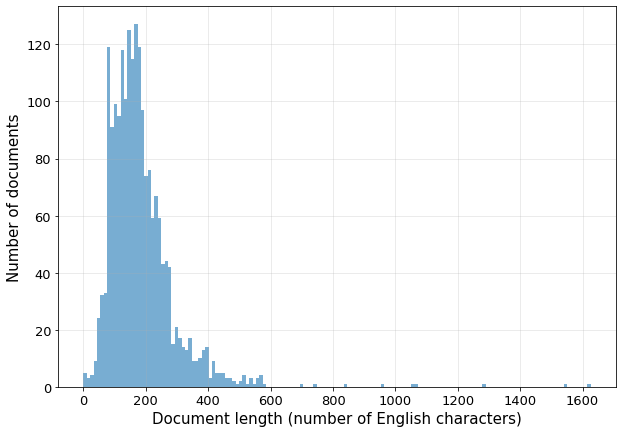

mean document length 183.50450901803606 ; median 164.0 ; std 110.15708168338256


In [17]:
len_tablets = np.array([len(v) for v in tablet_en_vals])
plt.figure(figsize=(10, 7))
plt.hist(len_tablets, bins=150, alpha=.6)
plt.grid(alpha=0.3)
plt.xlabel("Document length (number of English characters)", fontsize=15)
plt.ylabel("Number of documents", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)#, rotation=90)
plt.savefig("doc_length_hist", dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()
print("mean document length", np.mean(len_tablets), "; median", np.median(len_tablets), "; std", np.std(len_tablets))

What are the shortest documents with less than 50 characters? Most seem to be receipts; some just mark the year the tablet was issued and some just include a commodity label. Some have no texts remaining after my processing.

Note. in these examples, you can see how nasty the badly rendered superscripts look like.

In [18]:
# Chcek the shotest docs
for i in np.where(len_tablets < 50)[0]:
    print(tablet_nums[i], tablet_en_vals[i], "\n")

PF 18 1 3685 BAR of grain was taken to Shiraz. 

PF 91 apportion it . 24 th year. 

PF 100  

PF 102 ' 38 BAR of flour the unsak official delivered. 

PF 103  

PF 314 200 BAR of grain Parnaka received. 

PF 327 1 4373 BAR of flour Manaka received. 

PF 335  

PF 833 1 4241 BAR of flour Ushtana received as rations. 

PF 843 1 38 BAR of figs Kampiya received. 422 nd year. 

PF 1849  

PF 1862 Let Dapirukbama and Umaya deliver this flour. 

PF 1881 1 4 This grain was dispensed at Irkamas. 

PF 1883 1 3 Grain of the place Dutinus, 22 nd year. 

PF 1884 1 4 Grain of the place Rasinuzza, 22 nd year. 

PF 1885 ' 4 Grain of the place Umarzana, 22 nd year. 

PF 1886 Grain of the place Zarbashba, 22 nd year. 

PF 1893 1 224 ... of grain, 24 ... BAR. 

PF 1895 Sesame, 21 st year. 

PF 1896 ' 4 Fruit of the place Anzamannakka, 22 nd year. 

PF 1899 5 s Wine of the place Hiwuddama, 21 st year. 

PF 1900 ' 3 Wine of the place Haris, 23 rd year. 

PF 1901 1 Wine of the place Hinturrakka, 23 rd year.

Check the longest documents (with more than 550 characters). They are mostly letters or long accounts.

In [19]:
# Chcek the longest docs
for i in np.where(len_tablets > 550)[0]:
    print(tablet_nums[i], tablet_en_vals[i], "\n")

PF 865 ' x + 46 ½ [see note a] BAR of grain, supplied by Karkish, treasury workers subsisting on rations at Shiraz, whose apportionments are set by Baratkama, received as rations. 6 First and second and third months, 28 th year. 10 171 man, a keeper of atna, 6 ; 6 men, etip workers , each 4 ; 1 man, a tapmikilkira, 4 ; 2 men, attendants, each 4 ; 10 men, treasury workers , each 3 ½; 4 men, ramikurrash workers , each 3 ; 4 men, handlers of hazarna, each 3 ; 5 men, mulatap workers , each 3 . 18 225 boys each 21 , 9 boys each 2 , 9 boys each 1 , 1 boy 1 , 6 boys each ½. 23 271 woman, a chief, 5 ; 51 women, each 2 ; 11 women, "ration makers," each 2 . 2 321 girl 2 ., 2 girls each 2 , 3 girls each 1 I, 

PF 866 1 6896 BAR of grain, supplied by Irsena, treasury workers subsisting on rations, whose apportionments are set by Baratkama, received at Rakama, in the 28 th year, fifth month. 7 111 scribe receives 4 BAR; 1 etira receives 4 BAR; 1 treasurer receives 31 BAR; x attendants, each receive

From the English text of each tablet, determine the number associated with "year" and check whether it fits between years 12 to 29. We assume this to be the date of the tablet. Avoid extracting the numbers associated with "yearling" (for animals) and "years" where in most cases correspond to previous accounts of years before that are mentioned in the tablet.

In [20]:
# Extract years from the texts; some tablets can have more than one date in them. We ignore months for now.
tablet_years = []
for i, tablet in enumerate(tablet_en_vals):
    year = []
    ind_year = [m.start() for m in re.finditer('year', tablet)]
    # exclude yearling
    ind_yearling = [m.start() for m in re.finditer('yearling|years', tablet)]
    ind_years = [x for x in ind_year if x not in ind_yearling]
    for ind in ind_years:
        year_text = tablet[ind-6:ind+7]
        try:
            tmp_ = list(map(int, re.findall(r'\d{2}', year_text)))
            tmp = [t for t in tmp_ if (12 < t < 29)]
            year.append(tmp) 
        except:
            pass
    tablet_years.append(sum(year, []))

In [21]:
# # For a future project, think about extracting months and focusing on seasonal trends.

Compare the number of documents per year with Hallock's data. We miss about 100 tablets (2087 versus 1996), but this number is mostly associated with journals which we have excluded from the analysis. We miss the date assignment for about 200 tablets (including the 100 tablets just mentioned). This is not bad and will do for now. Hallock's data is incomplete anyways.

In [22]:
# compare with Hallock's data
Hallock_year_counts = list(zip(map(int, "13 14 15 16 17 18 19  20 21  22  23  24  25 26 27 28".split()), 
                               map(int, "2 4  20 21 40 89 121 81 148 418 437 167 67 8  30 61".split())))
print(" Number of tablets with date from Hallock: ", sum([i[1] for i in Hallock_year_counts]), 
      "(", "{0:.3g}".format(sum([i[1] for i in Hallock_year_counts]) * 100./2087), "%)\n",
      "Total Number of tablets published by Hallock: ", 2087, "\n")

emptys = [i for i,j in enumerate(tablet_years) if j==[]]
print("Number of tablets where at least a date is detected: ", sum([1 for i in tablet_years if i != []]), 
      "(", "{0:.3g}".format(sum([1 for i in tablet_years if i != []]) * 100./len(tablet_en_vals)), "%)\n",
      " Number of tablets with no detetcted date:", len(emptys), 
      "(", "{0:.3g}".format(len(emptys) * 100./len(tablet_en_vals)), "%)\n",
      "Total number of tablets: ", len(tablet_en_vals))


 Number of tablets with date from Hallock:  1714 ( 82.1 %)
 Total Number of tablets published by Hallock:  2087 

Number of tablets where at least a date is detected:  1516 ( 76 %)
  Number of tablets with no detetcted date: 480 ( 24 %)
 Total number of tablets:  1996


Lets also compare the distribution of tablets over the years. For some years, mostly 18-19 and 22-23, Hallock has identified more tablets compared with my assignments. The results of my automated procedure closely compare with Hallock's and follows his general trend. 

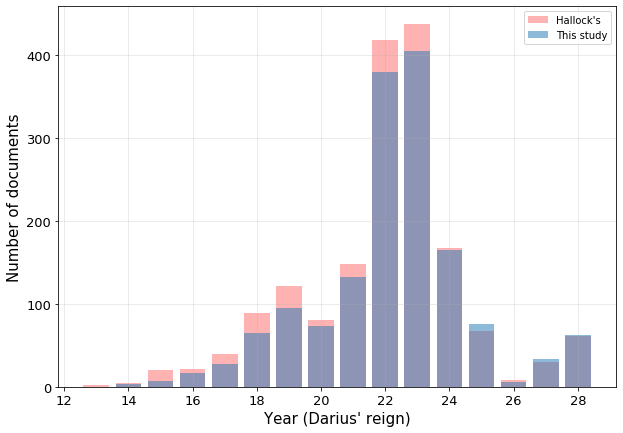

In [23]:
tmp = sum(tablet_years, [])
counts = Counter(tmp)
counts = counts.most_common()
counts = sorted(counts, key=lambda x: x[0])

plt.figure(figsize=(10, 7))
plt.bar([c[0] for c in Hallock_year_counts], [c[1] for c in Hallock_year_counts], alpha=.3, color='r')
plt.bar([c[0] for c in counts], [c[1] for c in counts], alpha=.5)
plt.grid(alpha=0.3)
plt.xlabel("Year (Darius' reign)", fontsize=15)
plt.ylabel("Number of documents", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(["Hallock's", "This study"])
plt.savefig("docs_by_date", dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()


And now, using statistical natural language processing (NLP) approaches, I extract named entities from each document. Named entities are proper nouns, e.g. names of people, places and dates. This way, we get a list of people and places that are mentioned in each tablet, stored in `tablet_ents`. This list along with `tablet_nums` (tablet numbers/ids) and `tablet_en_texts` (English translations of each tablet) will be frequently refered to and form the basis of the project. We will also keep track of the named entity label `entity_label_mapping`, i.e. whether it is a name of a person, a place, an organization and so on. These named entities will be the vertices of our network.

I have to do a fair amount of manual cleaning since the badly rendered superscripts greatly confuse the NLP model. Since I am not doing anything with the months, I will exclude that information from my named entity list. 

Further, king Darius II is identified by "king" in most of these tablets. Since "king" is not a named entity per se, I will have to manually include it in my named entity list whenever it occurs in a document/tablet.

In [24]:
# Extract proper nouns (names of people, places, etc.)
BLACKLISTED = ["According", "And", "All", "Afterwards", "Apply Extreme", "Cattle", "Concerning", "Corresponding", "Category", "Daily", "Each", "Ed", "From",
               "For", "His", "Her", "He", "Half", "Included", "Let", "May", "Make", "Monthly", "Ninth", "Not", "Now", "One", "Probably", "Per", "Persons",
               "Person", "Qa", "Rme", "She", "Seal", "See", "That", "Together", "Tablet", "There", "That", "This", "Their", "The", "Tell", "They", "These",
               "Two", "Third", "Then", "Total", "Upper", "Year", "First", "Second", "Third", "Fourth", "Fifth", "Sixth", "Seventh", "Eighth", "Ninth",
               "Tenth", "Eleventh", "Twelfth", "You", "Xg", "Man", "One"]
FILTERED = ["year", "month", "day", "first", "second", "third", "fourth", "sixth", "seventh", "eighth", "ninth", "tenth", "apply extreme",
            "eleventh", "twelfth", "category", "qa", "one", "ed", "two", "half", "concerning", "you", "xg", "rme", "man", "one"]               
tablet_ents = []
entity_label_mapping = defaultdict(set)
for num, tablet in enumerate(tablet_en_vals):
    nlp_doc = nlp(tablet)
    ents = []
    ents_labels = []
    for en in nlp_doc.ents:
        ent_text = en.text
        ent_text = re.sub("[^a-zA-Z ]+", " ", ent_text)
        ent_text = re.sub(" {2,}", " ", ent_text)
        ent_label = en.label_
        if ent_label not in ("DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL"):
            if not ent_text.istitle():
                ind_upper_case = [match.start() for match in re.finditer("[A-Z]", ent_text)]
                if ind_upper_case:
                    ent_text = ent_text[ind_upper_case[0]:]
            if ent_text.strip() != "":
                ents.append(ent_text)
                ents_labels.append(ent_label)
    entities = []
    for i, e in enumerate(ents):
        e_ = e.strip().split(" to ")
        for e_i in e_:
            if not (any(f in e_i.lower() for f in FILTERED) or e_i == "BAR" or len(e_i) <= 1 or
                    e_i.title() == "Nd" or e_i.title() == "Apply" or e_i.title() == "Extreme" or
                    e_i.title() == "Rme" or e_i == "" or e_i == " "):
                entities.append(e_i.title())
                entity_label_mapping[e_i.title()].add(ents_labels[i])
                
    entities = list(set([e for e in entities if e]))
    # Now mannually add the capitalized words that were not added
    if "king" in tablet and "king" not in entities:
        entities.append("King")
        entity_label_mapping["King"] = set(["PERSON",])
    capitals = re.findall('([A-Z][a-z]{2,})', tablet)
    for capital in capitals:
        if capital not in entities and capital not in BLACKLISTED:
            entities.append(capital)
            entity_label_mapping[capital] = set()
    tablet_ents.append(entities)

# print out some queries from the named entities list
print("Total number of distinct proper nouns: ", len(set(sum(tablet_ents, []))))
print("Total number of document including King: ", len([1 for t in tablet_ents if "King" in t]))
print("Total number of document including Parnaka: ", len([1 for t in tablet_ents if "Parnaka" in t]))
print("Total number of document including Sardis: ", len([1 for t in tablet_ents if "Sardis" in t]))
print("Total number of document including Egypt: ", len([1 for t in tablet_ents if ("Egypt" in t or "Egyptian" in t)]))
print("Total number of document including Sogdia: ", len([1 for t in tablet_ents if ("Sogdia" in t or "Sogdian" in t)]))
print("Total number of document including Babylon: ", len([1 for t in tablet_ents if ("Babylon" in t or "Babylonia" in t or "Babylonian" in t)]))
print("Total number of document including Susa: ", len([1 for t in tablet_ents if ("Susa" in t or "Susan" in t)]))
print("Total number of document including Elam: ", len([1 for t in tablet_ents if ("Elam" in t or "Elamite" in t)]))
print("Total number of document including Anshan: ", len([1 for t in tablet_ents if ("Anshan" in t or "Anshanite" in t)]))


Total number of distinct proper nouns:  1858
Total number of document including King:  200
Total number of document including Parnaka:  115
Total number of document including Sardis:  2
Total number of document including Egypt:  6
Total number of document including Sogdia:  3
Total number of document including Babylon:  15
Total number of document including Susa:  123
Total number of document including Elam:  135
Total number of document including Anshan:  6


In [25]:
print("Total number of document including Persepolis: ", len([1 for t in tablet_ents if "Persepolis" in t]))
print("Total number of document including Zishshawish: ", len([1 for t in tablet_ents if "Zishshawish" in t]))
print("Total number of document including Ushtana: ", len([1 for t in tablet_ents if "Ushtana" in t]))
print("Total number of document including Shiraz: ", len([1 for t in tablet_ents if ("Shiraz" in t or "Shirazi" in t)]))


Total number of document including Persepolis:  124
Total number of document including Zishshawish:  79
Total number of document including Ushtana:  84
Total number of document including Shiraz:  31


In [26]:
entity_label_mapping["Zishshawish"], entity_label_mapping["Elam"], entity_label_mapping["Susa"]

({'GPE'}, {'ORG', 'PERSON'}, {'GPE'})

In [27]:
# Form a dataframe for future referencing, and check its top few rows
tablet_data = pd.DataFrame({"tablet_en_texts": tablet_en_vals, "tablet_nums": tablet_nums,
                            "tablet_ents": tablet_ents, "tablet_years": tablet_years})
tablet_data.head()

tablet_en_texts tablet_nums  \
0  30 BAR of grain was taken to Anshan, 17 th yea...        PF 1   
1  1 640 BAR of grain, supplied by Zimakka, was t...        PF 2   
2  ' 511 BAR of barley loaves, supplied by Bakaba...        PF 3   
3  1 56 BAR of ..... grain, supplied by Muka, was...        PF 4   
4  1 A 370 . 4 BAR of grain was taken to Persepol...        PF 5   

                          tablet_ents tablet_years  
0             [Anshan, Makus, Umanna]     [17, 16]  
1  [Persepolis, Zimakka, Ashbatashda]         [17]  
2              [Persepolis, Bakabada]         [24]  
3                  [Muka, Persepolis]         [24]  
4              [Persepolis, Mannunda]           []

In [28]:
tablet_data.loc[0, "tablet_en_texts"]

'30 BAR of grain was taken to Anshan, 17 th year. 130 BAR of grain was taken to Anshan, 16 th year. This total of grain was taken to Anshan. 8 Makus received it. 9 Umanna is to apportion it .'

In [29]:
tablet_data.loc[1, "tablet_en_texts"]

'1 640 BAR of grain, supplied by Zimakka, was taken to Persepolis for the royal stores. 6 717 th year. Ashbatashda received it .'

In [30]:
# What years are mentioned in tablets which also mention Karkish
sorted(Counter(sum(tablet_data[tablet_data["tablet_ents"].map(lambda x: "Karkish" in x)].tablet_years.values, [])).most_common(),
       key=lambda x: x[0])



[(16, 11),
 (17, 4),
 (18, 6),
 (19, 5),
 (20, 3),
 (21, 3),
 (22, 15),
 (23, 33),
 (24, 11),
 (25, 2),
 (26, 1),
 (27, 1),
 (28, 4)]

In [31]:
# What years are mentioned in tablets which also mention Suddayauda
sorted(Counter(sum(tablet_data[tablet_data["tablet_ents"].map(lambda x: "Suddayauda" in x)].tablet_years.values, [])).most_common(),
       key=lambda x: x[0])



[(15, 1),
 (18, 2),
 (19, 4),
 (20, 5),
 (21, 11),
 (22, 9),
 (23, 32),
 (24, 4),
 (25, 8)]

In [32]:
# What years are mentioned in tablets which also mention Ushtana
sorted(Counter(sum(tablet_data[tablet_data["tablet_ents"].map(lambda x: "Ushtana" in x)].tablet_years.values, [])).most_common(),
       key=lambda x: x[0])



[(15, 1),
 (16, 6),
 (17, 2),
 (18, 5),
 (19, 6),
 (20, 3),
 (21, 5),
 (22, 8),
 (23, 8),
 (24, 3),
 (25, 2),
 (27, 1),
 (28, 7)]

In [33]:
# What years are mentioned in tablets which also mention Parnakka
sorted(Counter(sum(tablet_data[tablet_data["tablet_ents"].map(lambda x: "Parnaka" in x)].tablet_years.values, [])).most_common(),
       key=lambda x: x[0])



[(17, 1),
 (18, 5),
 (19, 9),
 (20, 4),
 (21, 7),
 (22, 23),
 (23, 35),
 (24, 6),
 (25, 2)]

In [34]:
# What years are mentioned in tablets which also mention Irdumartiya
sorted(Counter(sum(tablet_data[tablet_data["tablet_ents"].map(lambda x: "Irdumartiya" in x)].tablet_years.values, [])).most_common(),
       key=lambda x: x[0])



[(15, 1), (22, 1), (23, 1), (24, 1), (26, 2)]

Gather some descriptive statistics and explore the data structure. First, look at the distribution of number of named entities per document. It seems that on average 3 named entities are mentioned together in a document. This distribution is more or less symmetric (slightly right skewed). There are a few documents where more than 10 named entities are mentioned together. No named entities were detected for a few documents (about 40). 

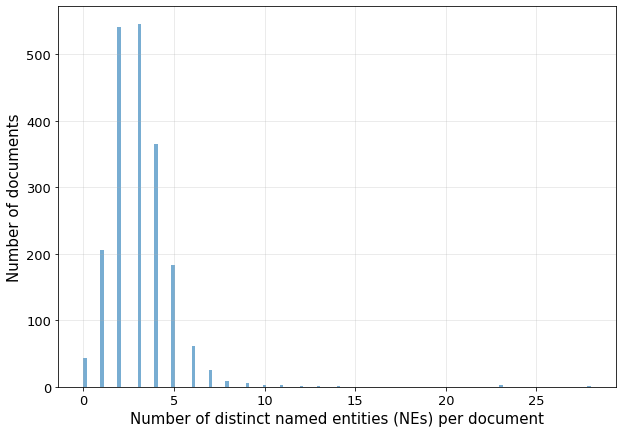

mean number of NEs per document 3.0746492985971945 ; median 3.0 ; std 1.772631680130227


In [35]:
plt.figure(figsize=(10, 7))
plt.hist(tablet_data["tablet_ents"].apply(len).values, bins=150, alpha=.6)
plt.grid(alpha=0.3)
plt.xlabel("Number of distinct named entities (NEs) per document", fontsize=15)
plt.ylabel("Number of documents", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig("ent_num_hist", dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()
print("mean number of NEs per document", np.mean(tablet_data["tablet_ents"].apply(len).values), "; median", np.median(tablet_data["tablet_ents"].apply(len).values), "; std", np.std(tablet_data["tablet_ents"].apply(len).values))

Check the tablets with no detected named entities. Good! There really is no named entity in these.

In [36]:
ents_per_doc = tablet_data["tablet_ents"].apply(len).values
for d in tablet_data.loc[np.where(ents_per_doc == 0)[0], "tablet_en_texts"].values[:10]:
    print(d)

1 3316 BAR of grain was taken to the nupishtash i.e. the mill? .
apportion it . 24 th year.

' 38 BAR of flour the unsak official delivered.

1 640 BAR of kurrusam tarmu grain has been deposited as kem to the account of 8 In the 22 nd year.
1 5500 BAR of kurrusam tarmu grain has been deposited to the account of the woman
1 6 ... BAR of grain has been carried forward as balance, and set aside as? marda, at ' 8 In the 22 nd year the account for men he received.
1 s 3 of 50 marris , 5 of 40 , 12 of 30 , 15 of 20 for a total of 35 vats, the battishekas payment is to be made. 8 9 The balance has not been made i.e. computed .
1 45 , 650 BAR of tarmu grain was delivered, and barley was received in exchange for it. 4 24 th year.


Check the tablets with more than 12 named entities in them. These are letters and long accounts.

In [37]:
ents_per_doc = tablet_data["tablet_ents"].apply(len).values
for d in tablet_data.loc[np.where(ents_per_doc > 12)[0], "tablet_en_texts"].values:
    print(d, "\n")

' 2 Tell Irtuppiya, Parnaka spoke as follows: 2 431 sheep and 7 "portions" [see note a] are to be issued as rations to women chiefs of the Pasa women , whose apportionments are set by Irsena. ' 10 They are to be issued as Saddukka the Zappiyan, and Matmabba at Atek, total 5 women. 10 22 Seventh, eighth, ninth, tenth, eleventh and twelfth months, total 6 months, in the 18 th year, and first, second, third, fourth, fifth, sixth, intercalary sixth, seventh, eighth, ninth, tenth, eleventh and twelfth months, total 13 months, in the 19 th year. 22 2 5 For a period of a grand total of 19 months, they receive for a whole year each 4 sheep. 25 Ansukka wrote the text . 26 27 He received the dumme from Nanitin. 27 28 Maraza knew about this. 2 8 2 9 The sealed document was delivered at Tamukkan in the district of Ranmesa. [Category K 2 ] 

3 Tell Parnaka, Ukama and his companion s spoke as follows: 3 ~May god and king become thy Shiri! 7 In the 20 th year, the grain which is set aside in our tidd

Now plot the pareto chart of named entities ocurrence in documents. This plots will show us the significant few (the left side of the plot) and the trivial many (the right side of the plot) among the named entities. This will also be useful to help us identify the important vertices in the network. 

First, we will zoom in on the left part of the plot where the significant named entities are located. The significant named entities correspond to those which are mentioned in more documents compared to the other named entities.
An interesting picture emerges. We see clear breakpoints among entities, indicated by drops in the blue bars. The king identifies the most significant named entity, followed by a small group of named entities--perhaps the highest class of officials after the king. Parnaka is in this group. This is followed by a slightly larger group of named entities, which perhaps compose the second class of high officials. 

We now zoom out to see the full chart. As seen in the second pareto chart below, after the king and these two groups, there is a large group of named entities, with more or less similar mentions in tablets, till we see two smaller drops as seen on the blue bars. This drop can also be detected as a shallow break on the cumulative percentage plot (orange line) around 70% and 80% (according to the left y-axis). It is difficult to see which entities correspond to these breakpoints. 

We zoom in the third plot on this range to see where this break happens.

Number of documents with each named entity [('King', 200), ('Elamite', 129), ('Persepolis', 124), ('Susa', 119), ('Parnaka', 115)] ... [('Teyauka', 1), ('Bawuk', 1), ('Shumama', 1), ('Attam', 1), ('Miriya', 1), ('Ing Panda', 1)]


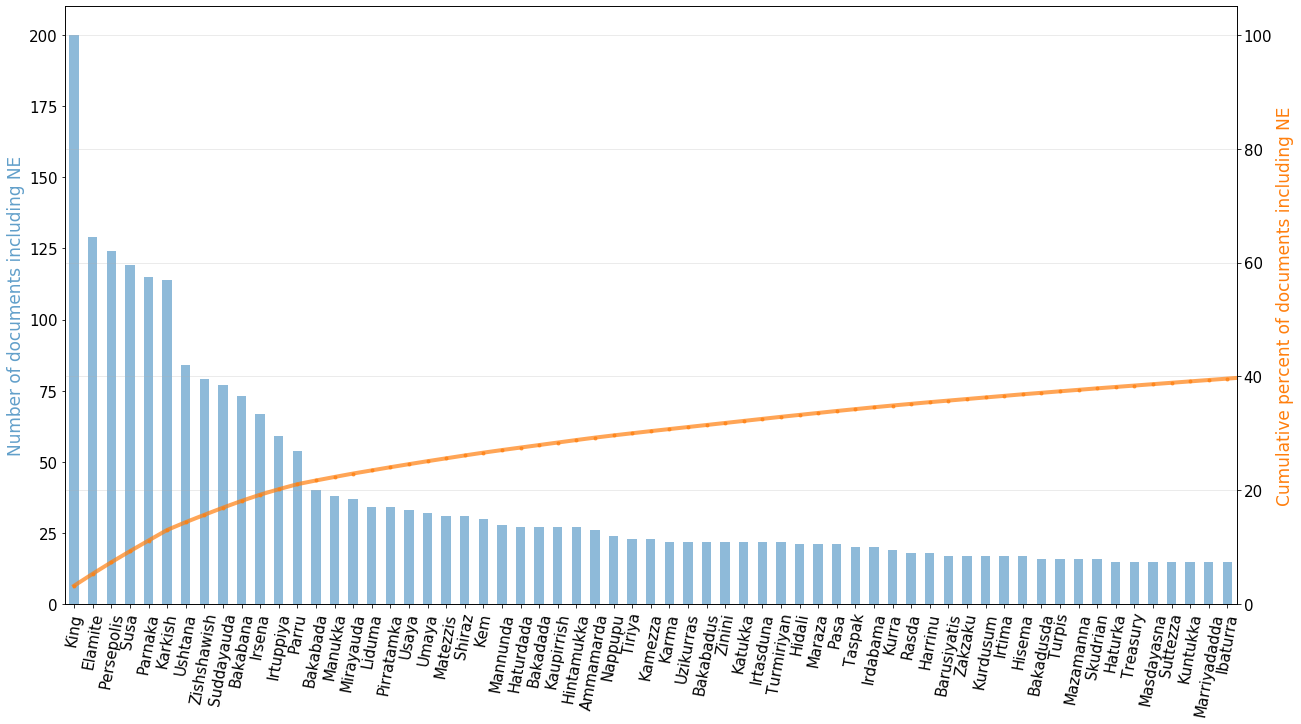

In [38]:
ent_counts = list(Counter(itertools.chain(*tablet_ents)).most_common())
print("Number of documents with each named entity", ent_counts[:5], "...", ent_counts[-6:])

x_min = 0
x_max = np.where(np.array([e[1] for e in ent_counts]) >= 15)[0][-1] 
df = pd.DataFrame()
df["pareto"] = 100. * np.array([e[1] for e in ent_counts]).cumsum() / np.array([e[1] for e in ent_counts]).sum()
df["ent_count"] = [e[1] for e in ent_counts]
df["ent"] = [e[0] for e in ent_counts]

fig, axes = plt.subplots(figsize=(21, 11))
ax1 = df.plot(use_index=True, y="ent_count",  kind="bar", alpha=0.5, ax=axes)
ax2 = df.plot(use_index=True, y="pareto", marker=".", color="C1", kind="line", ax=axes, secondary_y=True, alpha=0.7, lw=4)
ax2.set_ylim([0, 105])
axes.get_legend().remove()
axes.set_xlim([x_min-0.5, x_max+0.5])
axes.set_xticklabels([e[0] for e in ent_counts][:x_max+1], rotation=80)
ax1.set_ylabel("Number of documents including NE", fontsize=17, color="C0", alpha=0.7)
ax2.set_ylabel("Cumulative percent of documents including NE", fontsize=17, color="C1")
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)
plt.grid(alpha=0.3)
plt.savefig("Pareto of NE counts", dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()


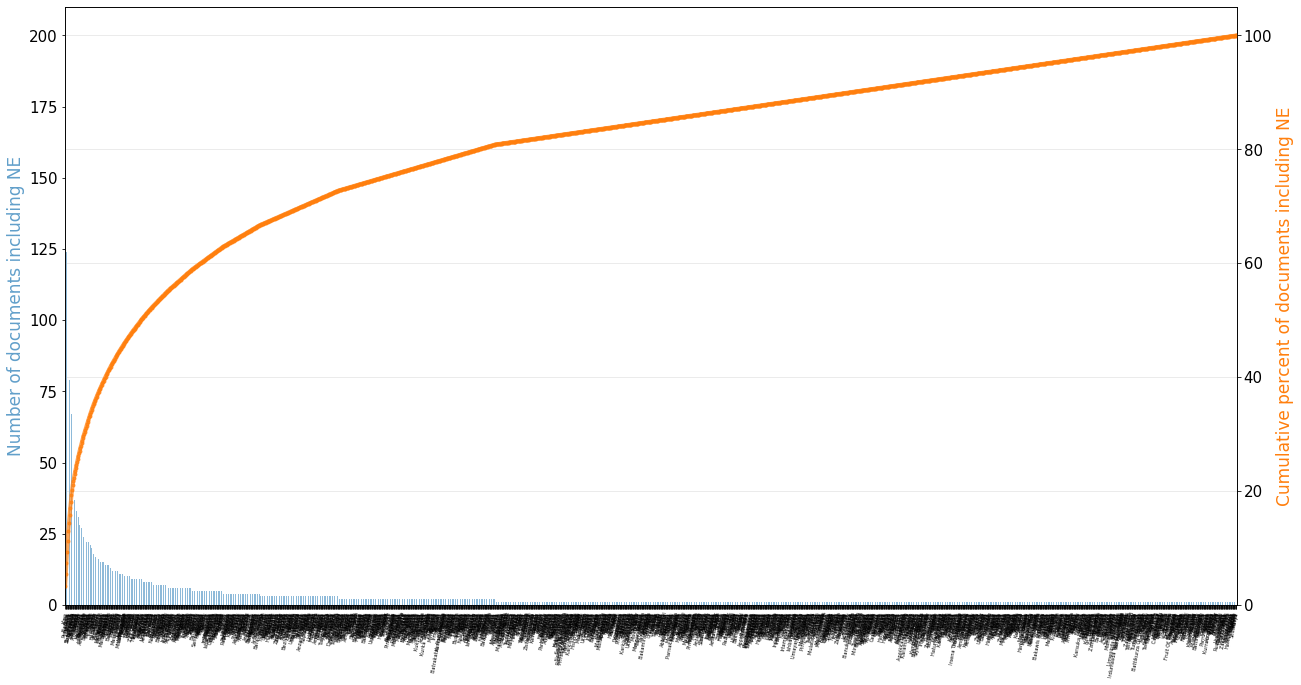

In [39]:
x_min = 0
x_max = np.where(np.array([e[1] for e in ent_counts]) >= 0)[0][-1] 
df = pd.DataFrame()
df["pareto"] = 100. * np.array([e[1] for e in ent_counts]).cumsum() / np.array([e[1] for e in ent_counts]).sum()
df["ent_count"] = [e[1] for e in ent_counts]
df["ent"] = [e[0] for e in ent_counts]

fig, axes = plt.subplots(figsize=(21, 11))
ax1 = df.plot(use_index=True, y="ent_count",  kind="bar", alpha=0.5, ax=axes)
ax2 = df.plot(use_index=True, y="pareto", marker=".", color="C1", kind="line", ax=axes, secondary_y=True, alpha=0.7, lw=4)
ax2.set_ylim([0, 105])
axes.get_legend().remove()
axes.set_xlim([x_min-0.5, x_max+0.5])
axes.set_xticklabels([e[0] for e in ent_counts][:x_max], rotation=80)
ax1.set_ylabel("Number of documents including NE", fontsize=17, color="C0", alpha=0.7)
ax2.set_ylabel("Cumulative percent of documents including NE", fontsize=17, color="C1")
ax1.tick_params(axis="x", labelsize=5)
ax1.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)
plt.grid(alpha=0.3)
plt.savefig("Pareto of NE counts_zoom out", dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()


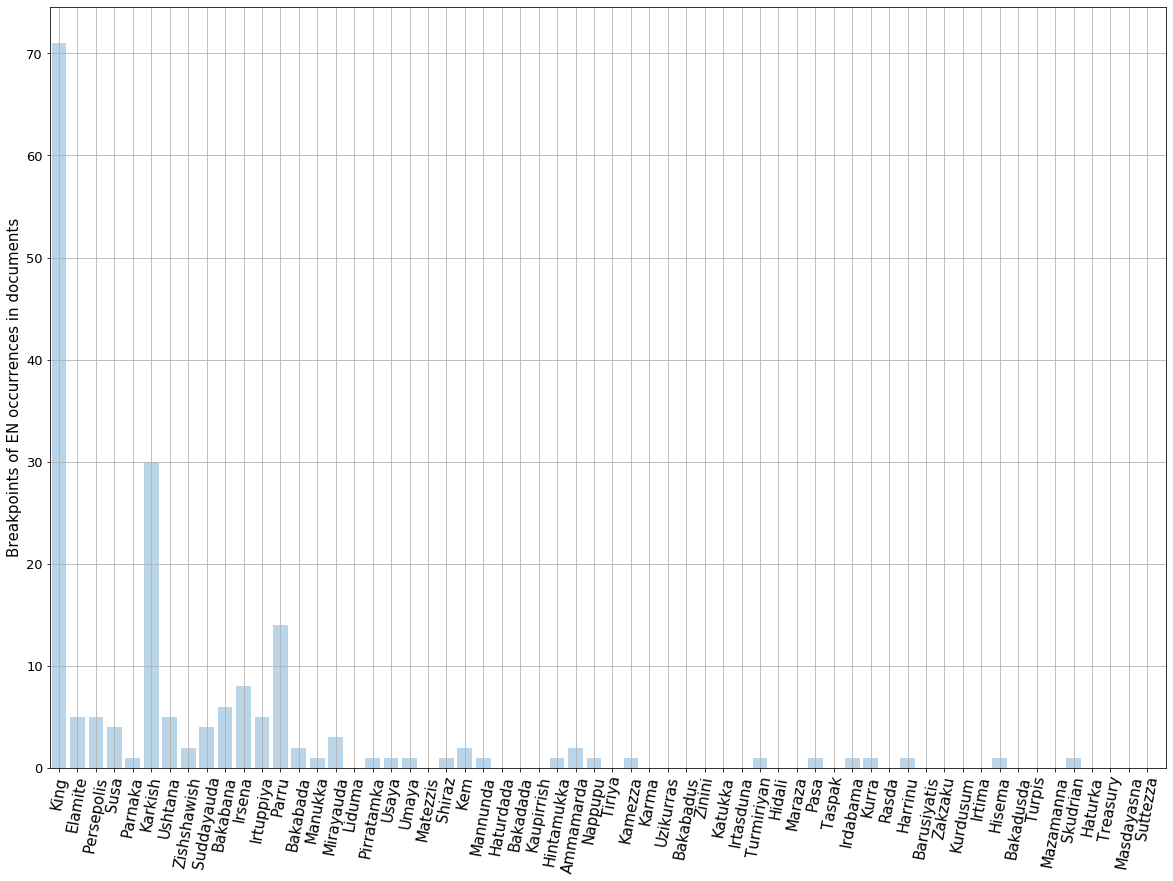

In [40]:
# See break points
x_max = 60
plt.figure(figsize=(20, 14))
plt.bar([e[0] for e in ent_counts][:-1], -1 * np.ediff1d(np.array([e[1] for e in ent_counts])), alpha=.3)
plt.xlim([-0.5, x_max])
plt.ylabel("Breakpoints of EN occurrences in documents", fontsize=15)
plt.xticks(ticks=range(x_max), labels=[e[0] for e in ent_counts][:x_max], rotation=80, fontsize=15)
plt.yticks(fontsize=13)
plt.grid()
plt.savefig("Break points", dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()
# Ammamarda's name has different variations: Anmamarda (p 667), Hammamarudda (p 689), Hamamarda (p 689).
# Karkish's name has different variations: Karkishsha (p 711), Karkashsha (p 711), 

### Lets start the network analysis.

We will focus on the top 100 and significant named entities according to the pareto chart. Below we see these 100 named entities. These named entities compose about 50% of the mentions in tablets. 

We then construct the adjacency matrix of these named entities. The adjacency matrix shows how close are each pair of named entities to each other. If two named entities i and j occur together in many documents, they are considered closely associated, and the cell corresponding to both i and j in the adjacency matrix will have a high value. On the other hand, if two named entities rarely appear together in documents, they are not affiliated, and their adjacency value is low. This adjacency matrix will be used to construct the network graph. 

The diagonal values of the adjacency matrix show the degree of each vertex (named entity), which corresponds to the number of times that named entities appears in a document. At the bottom left corner, we have the named entities with highest degree (the king, who is mentioned in about 200 documents), followed by Elamite, Persepolis, Susa, karkish and Parnaka. As we move towards the right, the named entities appear in less and less documents as indicated by the lower values on the diagonals. Upirradda, the last named entity among the top 100 entities, appears in about 15 documents.

The off-diagonal values between each two named entities, king and Parnaka for example, indicate in how many documents both entities co-occur. 

Ultimately, we want to see if there are clusters of named entities: groups of named entities that occur together in some documents in which other named entities do not occur. 

0 100


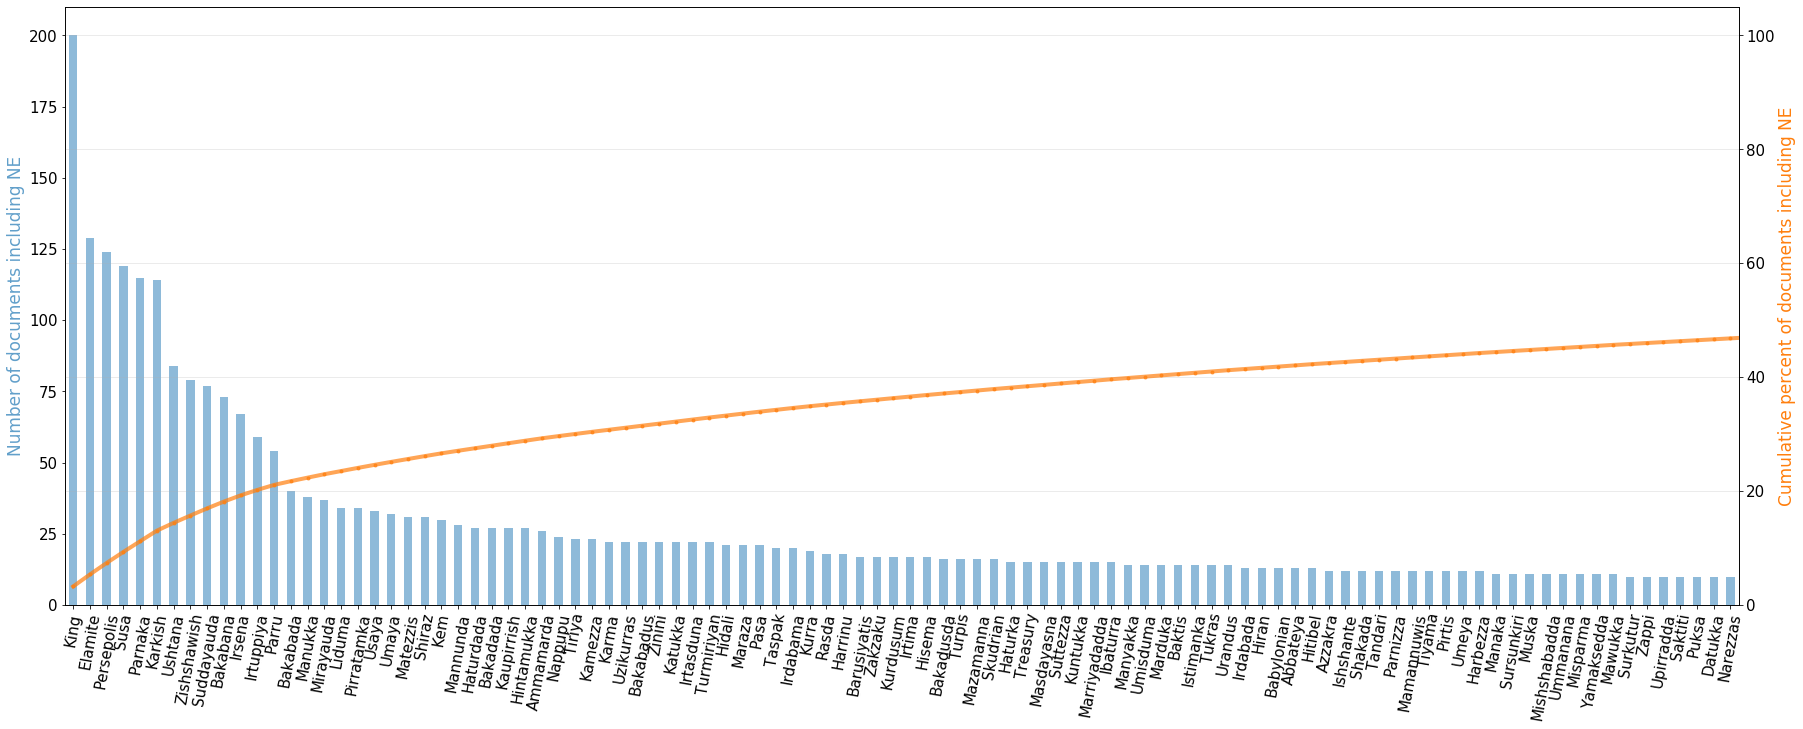

In [77]:
# x_min, x_max = 20, 200 #13
x_min, x_max = 0, 100
print(x_min, x_max)
df = pd.DataFrame()
df["pareto"] = 100. * np.array([e[1] for e in ent_counts]).cumsum() / np.array([e[1] for e in ent_counts]).sum()
df["ent_count"] = [e[1] for e in ent_counts]
df["ent"] = [e[0] for e in ent_counts]

fig, axes = plt.subplots(figsize=(30, 11))
ax1 = df.plot(use_index=True, y="ent_count",  kind="bar", alpha=0.5, ax=axes)
ax2 = df.plot(use_index=True, y="pareto", marker=".", color="C1", kind="line", ax=axes, secondary_y=True, alpha=0.7, lw=4)
ax2.set_ylim([0, 105])
axes.get_legend().remove()
axes.set_xlim([x_min-0.5, x_max-0.5])
axes.set_xticklabels([e[0] for e in ent_counts][:x_max+1], rotation=80)
ax1.set_ylabel("Number of documents including NE", fontsize=17, color="C0", alpha=0.7)
ax2.set_ylabel("Cumulative percent of documents including NE", fontsize=17, color="C1")
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)
plt.grid(alpha=0.3)
plt.savefig("Pareto of NE counts_{} ents".format(x_max-x_min), dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()


Number of documents that include these named entities: 1490 out of 1996 total documents


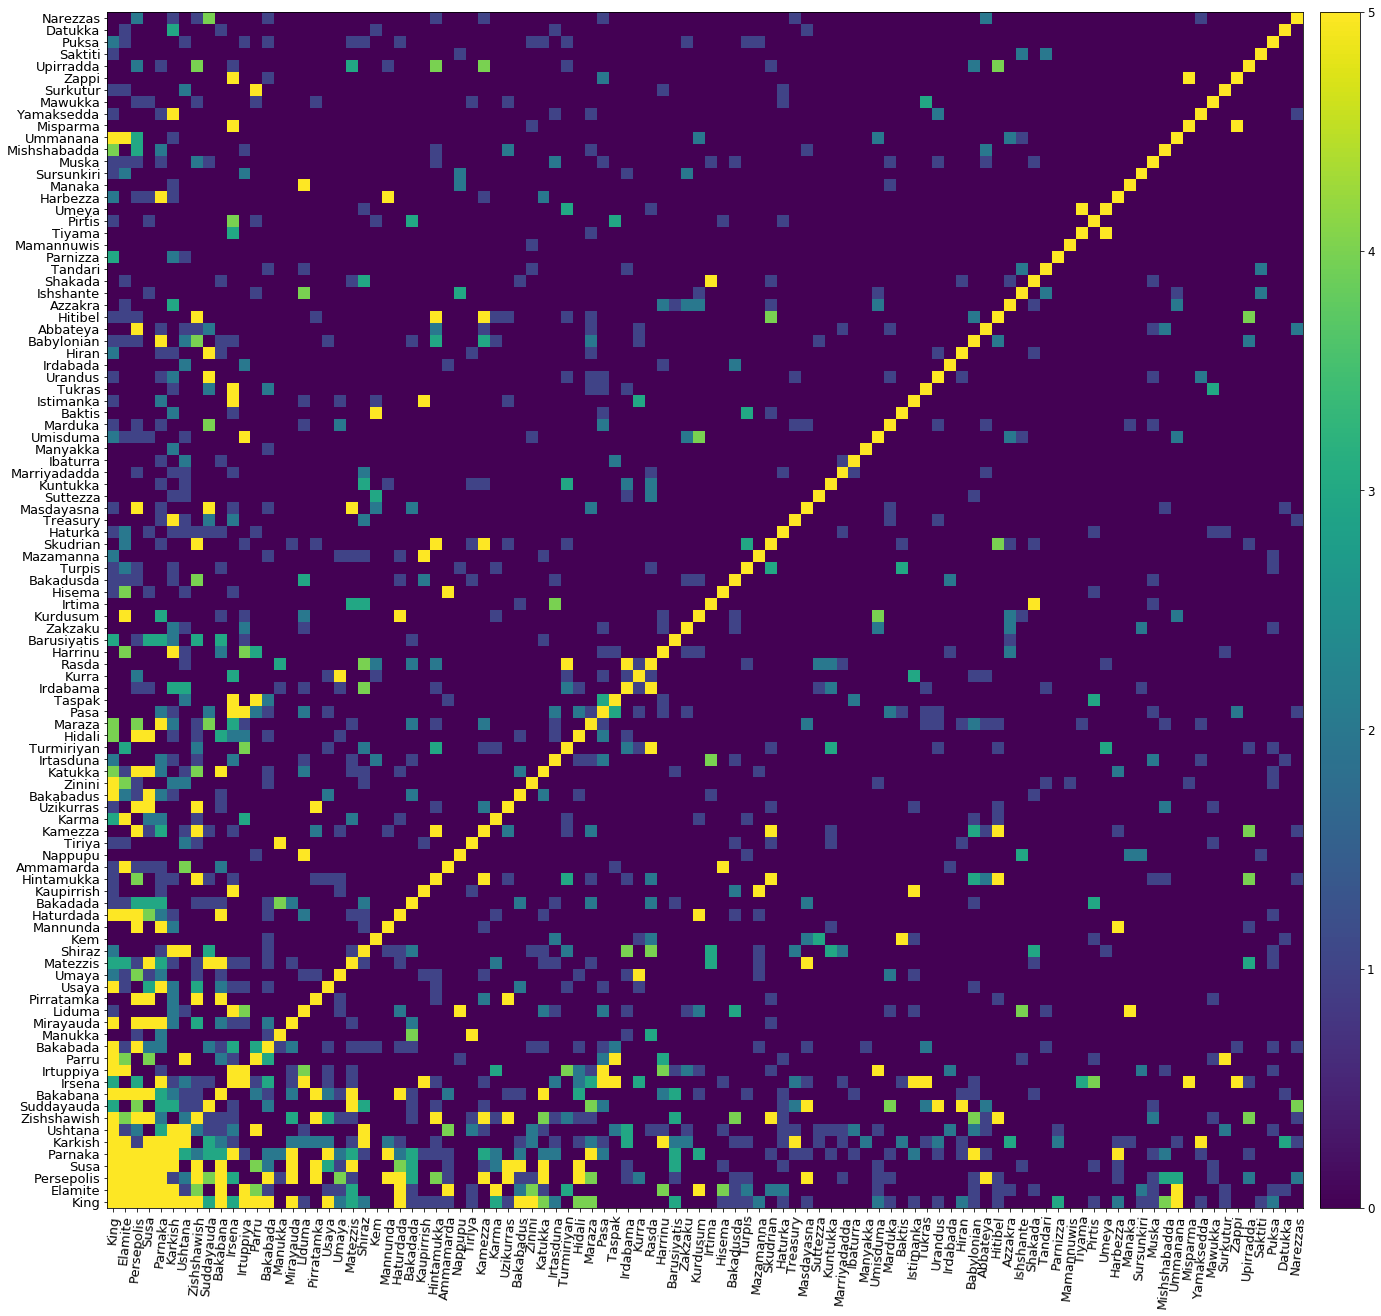

In [42]:
# Create the adjacency matrix of ENs for the network
ents = [e[0] for e in ent_counts][x_min:x_max]
ent_dict = {ent: i for i, ent in enumerate(ents)}

M = np.zeros((len(tablet_ents), len(ents)))
for i in range(len(tablet_ents)):
    ents_i = tablet_ents[i]
    j = [ent_dict[e] for e in ents_i if e in ents]
    M[i, j] = 1

print("Number of documents that include these named entities: {} out of {} total documents".format(
    (M.sum(axis=1) != 0).sum(), M.shape[0]))
# Plot the document frequency matrix
# plt.figure(figsize=(15, 15))
# plt.imshow(M, origin="lower")
# plt.ylabel("Tablet number", fontsize=15)
# ax = plt.gca()
# ax.set_xticks(range(len(ents)))
# ax.set_xticklabels(ents, rotation=80, fontsize=10)
# plt.yticks(fontsize=13)
# plt.savefig("EN doc matrix", dpi=None, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
# plt.show()


# Calculate the adjacency matrix from the document frequency matrix and image it
A = M.T @ M

plt.figure(figsize=(30, 22))
ax = plt.gca()
im = ax.imshow(A, origin="lower", vmax=5)
ax.set_xticks(range(len(ents)))
ax.set_xticklabels(ents, rotation=85, fontsize=13)
ax.set_yticks(range(len(ents)))
ax.set_yticklabels(ents, fontsize=13)
cbar = plt.colorbar(im, pad=.01, aspect=30) 
cbar.ax.tick_params(labelsize=12)
plt.savefig("Adjacency matrix", dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()

The diagonal elements on the adjacency matrix are the degree of each entity. The degree is a measure of connectivity. If a named entity has a high degree, it is connected to many other named entities.

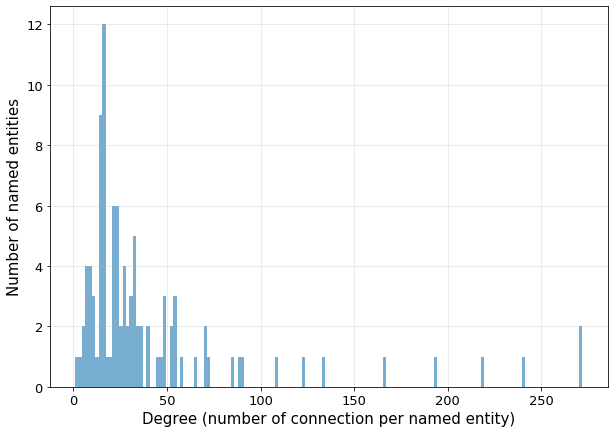

mean degree 42.94 ; median 23.5 ; std 53.512581698138995


In [43]:
# histogram of named entity degrees
degrees = A.sum(axis=1)-np.diagonal(A)
plt.figure(figsize=(10, 7))
plt.hist(degrees, bins=150, alpha=.6)
plt.grid(alpha=0.3)
plt.xlabel("Degree (number of connection per named entity)", fontsize=15)
plt.ylabel("Number of named entities", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.savefig("NE_degree_hist", dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()
print("mean degree", np.mean(degrees), "; median", np.median(degrees), "; std", np.std(degrees))


In [44]:
[ents[i] for i in np.where(degrees > 100)[0]]

['King',
 'Elamite',
 'Persepolis',
 'Susa',
 'Parnaka',
 'Karkish',
 'Zishshawish',
 'Bakabana',
 'Irsena']

In [45]:
# Which anmed entities are included? Also check their types according to `entity_label_mapping`
# for ent in ents:
#     print("{} : {}".format(ent, entity_label_mapping[ent]))

We try two different approaches to clustering of the named entities: spectral clustering and community finding rooted in graph and network theory. We will manually set the number of clusters, `K`, and let the algorithms find the optimal groups. The number of clusters can be determined automatically using different criteria. The intuition is that an optimal result produces clusters with strong inter-connectivity and high adjacency among cluster memebers relative to outer cluster connections.

We will compare the results of these two approaches, their similarities and differences. Further investiation into historical sources will help to see if the shared results between both approaches really reflects knwon historical circumstances. 

The resulting clusters from the first approach will be used to replot the adjacency matrix accordingly. Larger clusters (with more named entity members) are plotted first, followed by smaller clusters. We see blocks of interconnected clusters in this reorderd image. The connectivity pattern of each cluster indicated a hierarchy where a few named entities play a central role.

spectral clustering...


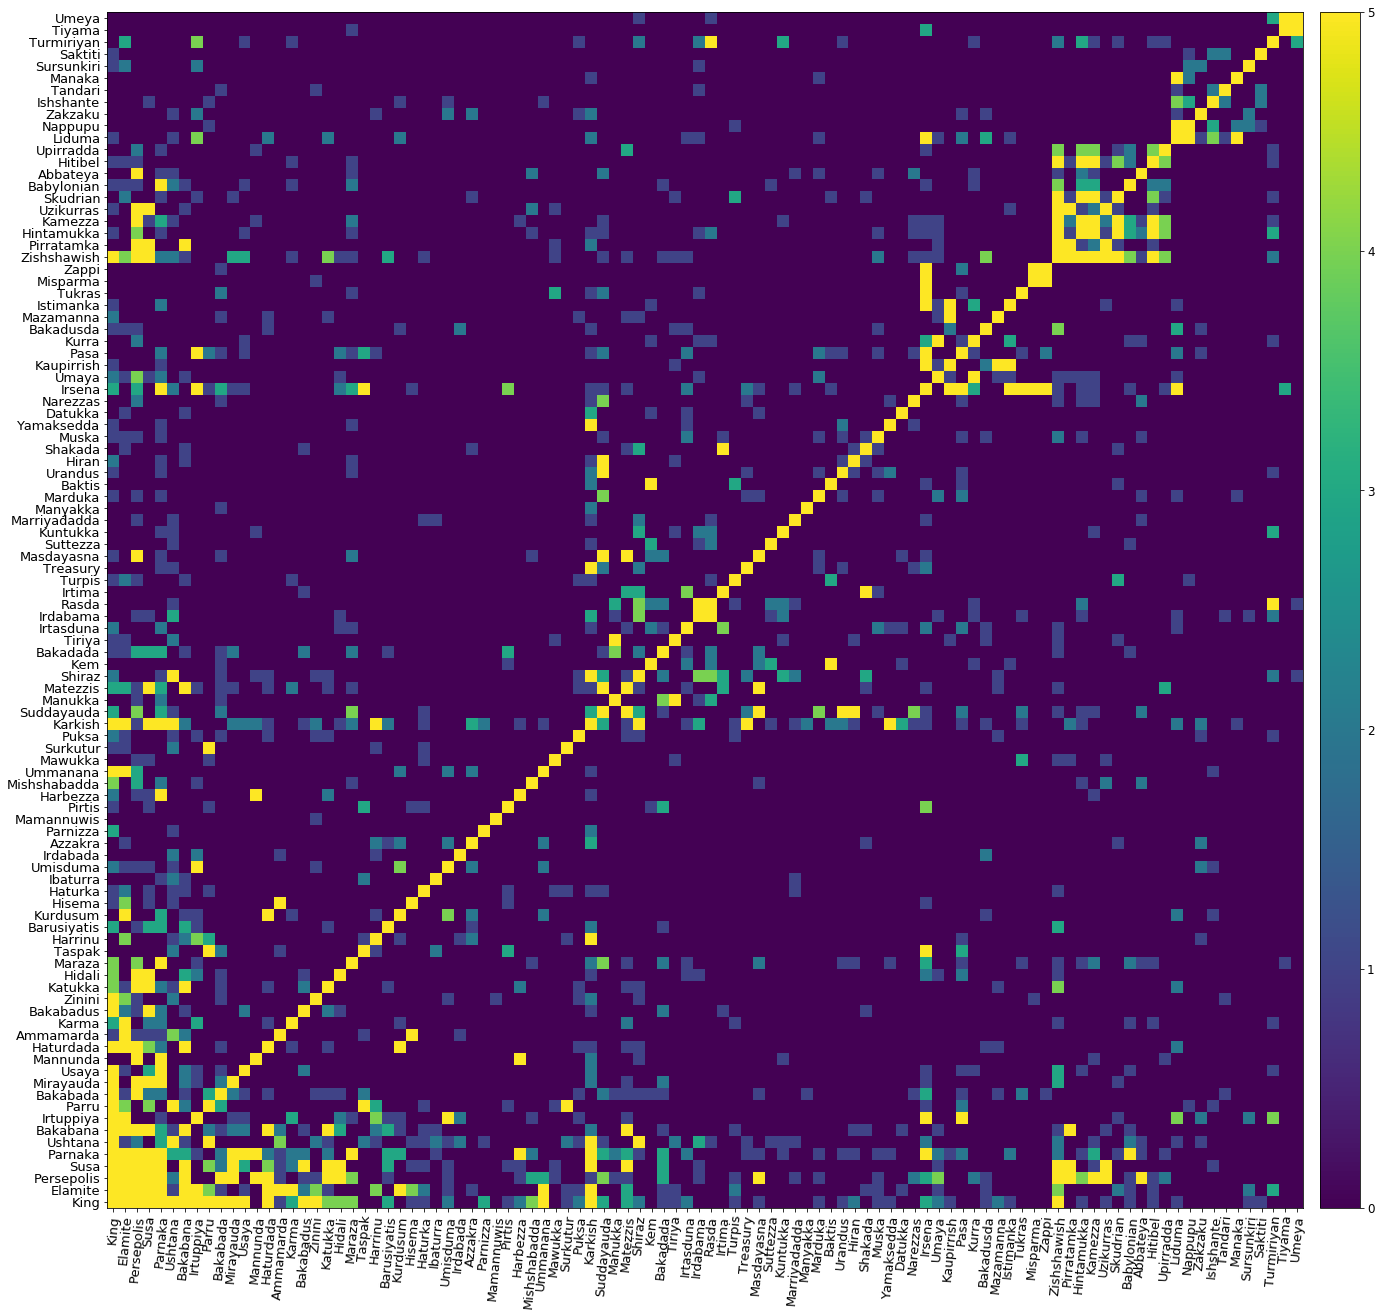

In [46]:
A = M.T @ M
# K = 9 for x_min, x_max = 20, 200 #13
K = 6

print('spectral clustering...')
np.random.seed(0)
sc = SpectralClustering(K, affinity='precomputed', n_init=4000, assign_labels='discretize')
sc.fit(A)

ranked_clusters = [i[0] for i in list(Counter(sc.labels_).most_common())]
ids_k = {k: np.where(sc.labels_==k)[0] for k in ranked_clusters}
ordered_A = reordering_by_clusters(A, ranked_clusters, ids_k)
ordered_ents_ind = sum(list(map(list, [ids_k[k] for k in ranked_clusters])), [])
ordered_ents = [ents[i] for i in ordered_ents_ind]

plt.figure(figsize=(30,22))
ax = plt.gca()
im = ax.imshow(ordered_A, origin="lower", vmax=5)
ax.set_xticks(range(len(ordered_ents)))
ax.set_xticklabels(ordered_ents, rotation=85, fontsize=13)
ax.set_yticks(range(len(ordered_ents)))
ax.set_yticklabels(ordered_ents, fontsize=13)
cbar = plt.colorbar(im, pad=0.01, aspect=30) 
cbar.ax.tick_params(labelsize=12)
# plt.savefig("Spectral clustering_ordered adjacency matrix_{} clusters".format(K),dpi=1000,
#             facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()

In [47]:
ordered_ents

['King',
 'Elamite',
 'Persepolis',
 'Susa',
 'Parnaka',
 'Ushtana',
 'Bakabana',
 'Irtuppiya',
 'Parru',
 'Bakabada',
 'Mirayauda',
 'Usaya',
 'Mannunda',
 'Haturdada',
 'Ammamarda',
 'Karma',
 'Bakabadus',
 'Zinini',
 'Katukka',
 'Hidali',
 'Maraza',
 'Taspak',
 'Harrinu',
 'Barusiyatis',
 'Kurdusum',
 'Hisema',
 'Haturka',
 'Ibaturra',
 'Umisduma',
 'Irdabada',
 'Azzakra',
 'Parnizza',
 'Mamannuwis',
 'Pirtis',
 'Harbezza',
 'Mishshabadda',
 'Ummanana',
 'Mawukka',
 'Surkutur',
 'Puksa',
 'Karkish',
 'Suddayauda',
 'Manukka',
 'Matezzis',
 'Shiraz',
 'Kem',
 'Bakadada',
 'Tiriya',
 'Irtasduna',
 'Irdabama',
 'Rasda',
 'Irtima',
 'Turpis',
 'Treasury',
 'Masdayasna',
 'Suttezza',
 'Kuntukka',
 'Marriyadadda',
 'Manyakka',
 'Marduka',
 'Baktis',
 'Urandus',
 'Hiran',
 'Shakada',
 'Muska',
 'Yamaksedda',
 'Datukka',
 'Narezzas',
 'Irsena',
 'Umaya',
 'Kaupirrish',
 'Pasa',
 'Kurra',
 'Bakadusda',
 'Mazamanna',
 'Istimanka',
 'Tukras',
 'Misparma',
 'Zappi',
 'Zishshawish',
 'Pirratamka

In [48]:
# Add their labels, manually created using the assigned labels
MANUAL_LABELS = {
"King": "PERSON",
"Elamite": "GPE",
"Persepolis": "GPE",
"Susa": "GPE",
"Parnaka": "PERSON",
"Ushtana": "PERSON",
"Bakabana": "PERSON",
"Irtuppiya": "PERSON",
"Parru": "PERSON",
"Bakabada": "PERSON",
"Mirayauda": "PERSON",
"Usaya": "PERSON",
"Mannunda": "PERSON",
"Haturdada": "PERSON",
"Ammamarda": "PERSON",
"Karma": "PERSON",
"Zinini": "PERSON",
"Katukka": "PERSON",
"Hidali": "GPE",
"Bakabadus": "PERSON",
"Taspak": "GPE",
"Harrinu": "GPE",
"Barusiyatis": "PERSON",
"Kurdusum": "GPE",
"Hisema": "GPE",
"Haturka": "PERSON",
"Ibaturra": "PERSON",
"Umisduma": "PERSON",
"Irdabada": "PERSON",
"Azzakra": "PERSON",
"Parnizza": "PERSON",
"Mamannuwis": "PERSON",
"Pirtis": "PERSON",
"Harbezza": "PERSON",
"Mishshabadda": "PERSON",
"Ummanana": "PERSON",
"Mawukka": "PERSON",
"Surkutur": "GPE",
"Puksa": "PERSON",

"Karkish": "PERSON",
"Suddayauda": "PERSON",
"Manukka": "PERSON",
"Shiraz": "GPE",
"Matezzis": "GPE",
"Kem": "?",
"Bakadada": "PERSON",
"Tiriya": "PERSON",
"Irtasduna": "PERSON",
"Maraza": "PERSON",
"Irdabama": "PERSON",
"Rasda": "PERSON",
"Irtima": "PERSON",
"Turpis": "PERSON",
"Treasury": "GPE",
"Masdayasna": "PERSON",
"Suttezza": "PERSON",
"Kuntukka": "PERSON",
"Marriyadadda": "PERSON",
"Marduka": "PERSON",
"Manyakka": "PERSON",
"Baktis": "GPE",
"Urandus": "GPE",
"Hiran": "GPE",
"Shakada": "PERSON",
"Muska": "PERSON",
"Yamaksedda": "PERSON",
"Tamukkan" : "GPE",
"Datukka": "PERSON",

"Irsena": "PERSON",
"Umaya": "PERSON",
"Kaupirrish": "GPE",
"Pasa": "PERSON",
"Kurra": "GPE",
"Bakadusda": "PERSON",
"Mazamanna": "PERSON",
"Tukras": "GPE",
"Istimanka": "PERSON",
"Misparma": "PERSON",
"Zappi": "GPE",

"Zishshawish": "PERSON",
"Pirratamka": "PERSON",
"Hintamukka": "PERSON",
"Kamezza": "PERSON",
"Uzikurras": "GPE",
"Skudrian": "GPE",
"Babylonian": "GPE",
"Abbateya": "PERSON",
"Hitibel": "PERSON",
"Upirradda": "PERSON",

"Liduma": "GPE",
"Nappupu": "PERSON",
"Zakzaku": "GPE",
"Ishshante": "PERSON",
"Tandari": "GPE",
"Manaka": "PERSON",
"Sursunkiri": "GPE",
"Saktiti": "PERSON",

"Turmiriyan": "GPE",
"Tiyama": "PERSON",
"Umeya": "PERSON",
    
"Narezzas": "GPE",
}

for ent in MANUAL_LABELS.keys():
    entity_label_mapping[ent] = set([MANUAL_LABELS[ent] ,])

# Now map each label (PERSON, GPE) to a particular shape to be used for the vertex in the network
label_shape_mapping = {"PERSON": "circle", "GPE": "triangle-up"}

In [49]:
# Which entities occur most frequently with king
id_ = ordered_ents.index("King")
tmp = np.where(ordered_A[id_, :] > 0)[0][1:]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Elamite', 'GPE'), 40),
 (('Susa', 'GPE'), 26),
 (('Persepolis', 'GPE'), 20),
 (('Haturdada', 'PERSON'), 15),
 (('Karkish', 'PERSON'), 12),
 (('Parnaka', 'PERSON'), 12),
 (('Irtuppiya', 'PERSON'), 10),
 (('Ushtana', 'PERSON'), 9),
 (('Zinini', 'PERSON'), 7),
 (('Mirayauda', 'PERSON'), 7),
 (('Parru', 'PERSON'), 7),
 (('Zishshawish', 'PERSON'), 6),
 (('Ummanana', 'PERSON'), 6),
 (('Usaya', 'PERSON'), 6),
 (('Bakabada', 'PERSON'), 6),
 (('Bakabadus', 'PERSON'), 5),
 (('Bakabana', 'PERSON'), 5),
 (('Mishshabadda', 'PERSON'), 4),
 (('Maraza', 'PERSON'), 4),
 (('Hidali', 'GPE'), 4),
 (('Katukka', 'PERSON'), 4),
 (('Irsena', 'PERSON'), 3),
 (('Matezzis', 'GPE'), 3),
 (('Suddayauda', 'PERSON'), 3),
 (('Parnizza', 'PERSON'), 3),
 (('Barusiyatis', 'PERSON'), 3),
 (('Karma', 'PERSON'), 3),
 (('Mazamanna', 'PERSON'), 2),
 (('Umaya', 'PERSON'), 2),
 (('Hiran', 'GPE'), 2),
 (('Irtasduna', 'PERSON'), 2),
 (('Shiraz', 'GPE'), 2),
 (('Puksa', 'PERSON'), 2),
 (('Harbezza', 'PERSON'), 2),
 (('Umisdum

In [50]:
# Which entities occur most frequently with Parnaka
id_ = ordered_ents.index("Parnaka")
tmp = np.where(ordered_A[id_, :] > 0)[0][1:]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Parnaka', 'PERSON'), 115),
 (('Susa', 'GPE'), 21),
 (('Mannunda', 'PERSON'), 16),
 (('Elamite', 'GPE'), 16),
 (('Persepolis', 'GPE'), 15),
 (('Mirayauda', 'PERSON'), 10),
 (('Maraza', 'PERSON'), 9),
 (('Harbezza', 'PERSON'), 8),
 (('Irsena', 'PERSON'), 6),
 (('Karkish', 'PERSON'), 6),
 (('Babylonian', 'GPE'), 5),
 (('Usaya', 'PERSON'), 5),
 (('Kamezza', 'PERSON'), 3),
 (('Bakadada', 'PERSON'), 3),
 (('Matezzis', 'GPE'), 3),
 (('Suddayauda', 'PERSON'), 3),
 (('Kurdusum', 'GPE'), 3),
 (('Barusiyatis', 'PERSON'), 3),
 (('Bakabana', 'PERSON'), 3),
 (('Ushtana', 'PERSON'), 3),
 (('Zishshawish', 'PERSON'), 2),
 (('Istimanka', 'PERSON'), 2),
 (('Pasa', 'PERSON'), 2),
 (('Umaya', 'PERSON'), 2),
 (('Irtasduna', 'PERSON'), 2),
 (('Manukka', 'PERSON'), 2),
 (('Mishshabadda', 'PERSON'), 2),
 (('Katukka', 'PERSON'), 2),
 (('Bakabadus', 'PERSON'), 2),
 (('Karma', 'PERSON'), 2),
 (('Haturdada', 'PERSON'), 2),
 (('Bakabada', 'PERSON'), 2),
 (('Upirradda', 'PERSON'), 1),
 (('Abbateya', 'PERSON'), 1

In [51]:
# Which entities occur most frequently with Karkish
id_ = ordered_ents.index("Haturdada")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Haturdada', 'PERSON'), 27),
 (('King', 'PERSON'), 15),
 (('Elamite', 'GPE'), 10),
 (('Kurdusum', 'GPE'), 6),
 (('Bakabana', 'PERSON'), 5),
 (('Persepolis', 'GPE'), 5),
 (('Susa', 'GPE'), 4),
 (('Liduma', 'GPE'), 2),
 (('Parnaka', 'PERSON'), 2),
 (('Mazamanna', 'PERSON'), 1),
 (('Bakadusda', 'PERSON'), 1),
 (('Shiraz', 'GPE'), 1),
 (('Matezzis', 'GPE'), 1),
 (('Karkish', 'PERSON'), 1),
 (('Puksa', 'PERSON'), 1),
 (('Katukka', 'PERSON'), 1),
 (('Karma', 'PERSON'), 1),
 (('Bakabada', 'PERSON'), 1)]

In [52]:
# Which entities occur most frequently with Susa
id_ = ordered_ents.index("Susa")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Susa', 'GPE'), 119),
 (('Persepolis', 'GPE'), 43),
 (('King', 'PERSON'), 26),
 (('Parnaka', 'PERSON'), 21),
 (('Zishshawish', 'PERSON'), 18),
 (('Bakabana', 'PERSON'), 18),
 (('Mirayauda', 'PERSON'), 15),
 (('Pirratamka', 'PERSON'), 14),
 (('Elamite', 'GPE'), 11),
 (('Katukka', 'PERSON'), 10),
 (('Uzikurras', 'GPE'), 9),
 (('Hidali', 'GPE'), 8),
 (('Bakabadus', 'PERSON'), 6),
 (('Matezzis', 'GPE'), 5),
 (('Karkish', 'PERSON'), 5),
 (('Haturdada', 'PERSON'), 4),
 (('Parru', 'PERSON'), 4),
 (('Bakadada', 'PERSON'), 3),
 (('Barusiyatis', 'PERSON'), 3),
 (('Usaya', 'PERSON'), 3),
 (('Karma', 'PERSON'), 2),
 (('Bakabada', 'PERSON'), 2),
 (('Ishshante', 'PERSON'), 1),
 (('Kamezza', 'PERSON'), 1),
 (('Umaya', 'PERSON'), 1),
 (('Irdabama', 'PERSON'), 1),
 (('Mawukka', 'PERSON'), 1),
 (('Harbezza', 'PERSON'), 1),
 (('Pirtis', 'PERSON'), 1),
 (('Umisduma', 'PERSON'), 1),
 (('Haturka', 'PERSON'), 1),
 (('Hisema', 'GPE'), 1),
 (('Ammamarda', 'PERSON'), 1)]

In [56]:
# Which entities occur most frequently with Persepolis
id_ = ordered_ents.index("Persepolis")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Persepolis', 'GPE'), 124),
 (('Susa', 'GPE'), 43),
 (('Bakabana', 'PERSON'), 26),
 (('King', 'PERSON'), 20),
 (('Zishshawish', 'PERSON'), 15),
 (('Parnaka', 'PERSON'), 15),
 (('Elamite', 'GPE'), 14),
 (('Abbateya', 'PERSON'), 13),
 (('Pirratamka', 'PERSON'), 12),
 (('Uzikurras', 'GPE'), 9),
 (('Mannunda', 'PERSON'), 9),
 (('Mirayauda', 'PERSON'), 8),
 (('Hidali', 'GPE'), 7),
 (('Katukka', 'PERSON'), 7),
 (('Kamezza', 'PERSON'), 5),
 (('Masdayasna', 'PERSON'), 5),
 (('Haturdada', 'PERSON'), 5),
 (('Bakabada', 'PERSON'), 5),
 (('Hintamukka', 'PERSON'), 4),
 (('Umaya', 'PERSON'), 4),
 (('Suddayauda', 'PERSON'), 4),
 (('Maraza', 'PERSON'), 4),
 (('Irsena', 'PERSON'), 3),
 (('Bakadada', 'PERSON'), 3),
 (('Ummanana', 'PERSON'), 3),
 (('Mishshabadda', 'PERSON'), 3),
 (('Upirradda', 'PERSON'), 2),
 (('Kurra', 'GPE'), 2),
 (('Narezzas', 'GPE'), 2),
 (('Ushtana', 'PERSON'), 2),
 (('Hitibel', 'PERSON'), 1),
 (('Babylonian', 'GPE'), 1),
 (('Bakadusda', 'PERSON'), 1),
 (('Muska', 'PERSON'), 1),

In [57]:
# Which entities occur most frequently with Elamite
id_ = ordered_ents.index("Elamite")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Elamite', 'GPE'), 129),
 (('King', 'PERSON'), 40),
 (('Karma', 'PERSON'), 21),
 (('Bakabana', 'PERSON'), 18),
 (('Parnaka', 'PERSON'), 16),
 (('Persepolis', 'GPE'), 14),
 (('Irtuppiya', 'PERSON'), 11),
 (('Susa', 'GPE'), 11),
 (('Haturdada', 'PERSON'), 10),
 (('Ummanana', 'PERSON'), 8),
 (('Ammamarda', 'PERSON'), 6),
 (('Karkish', 'PERSON'), 5),
 (('Kurdusum', 'GPE'), 5),
 (('Zishshawish', 'PERSON'), 4),
 (('Hisema', 'GPE'), 4),
 (('Harrinu', 'GPE'), 4),
 (('Zinini', 'PERSON'), 4),
 (('Parru', 'PERSON'), 4),
 (('Turmiriyan', 'GPE'), 3),
 (('Matezzis', 'GPE'), 3),
 (('Sursunkiri', 'GPE'), 2),
 (('Skudrian', 'GPE'), 2),
 (('Turpis', 'PERSON'), 2),
 (('Haturka', 'PERSON'), 2),
 (('Bakabadus', 'PERSON'), 2),
 (('Hitibel', 'PERSON'), 1),
 (('Babylonian', 'GPE'), 1),
 (('Bakadusda', 'PERSON'), 1),
 (('Umaya', 'PERSON'), 1),
 (('Datukka', 'PERSON'), 1),
 (('Muska', 'PERSON'), 1),
 (('Shakada', 'PERSON'), 1),
 (('Tiriya', 'PERSON'), 1),
 (('Bakadada', 'PERSON'), 1),
 (('Puksa', 'PERSON'), 

In [59]:
# Which entities occur most frequently with Karkish
id_ = ordered_ents.index("Karkish")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Karkish', 'PERSON'), 114),
 (('Ushtana', 'PERSON'), 14),
 (('Shiraz', 'GPE'), 13),
 (('King', 'PERSON'), 12),
 (('Yamaksedda', 'PERSON'), 8),
 (('Parnaka', 'PERSON'), 6),
 (('Treasury', 'GPE'), 5),
 (('Harrinu', 'GPE'), 5),
 (('Susa', 'GPE'), 5),
 (('Elamite', 'GPE'), 5),
 (('Datukka', 'PERSON'), 3),
 (('Irdabama', 'PERSON'), 3),
 (('Suddayauda', 'PERSON'), 3),
 (('Azzakra', 'PERSON'), 3),
 (('Zakzaku', 'GPE'), 2),
 (('Liduma', 'GPE'), 2),
 (('Pirratamka', 'PERSON'), 2),
 (('Urandus', 'GPE'), 2),
 (('Baktis', 'GPE'), 2),
 (('Manyakka', 'PERSON'), 2),
 (('Parnizza', 'PERSON'), 2),
 (('Barusiyatis', 'PERSON'), 2),
 (('Maraza', 'PERSON'), 2),
 (('Zinini', 'PERSON'), 2),
 (('Mannunda', 'PERSON'), 2),
 (('Usaya', 'PERSON'), 2),
 (('Mirayauda', 'PERSON'), 2),
 (('Bakabana', 'PERSON'), 2),
 (('Manaka', 'PERSON'), 1),
 (('Hintamukka', 'PERSON'), 1),
 (('Tukras', 'GPE'), 1),
 (('Bakadusda', 'PERSON'), 1),
 (('Pasa', 'PERSON'), 1),
 (('Irsena', 'PERSON'), 1),
 (('Narezzas', 'GPE'), 1),
 (('H

In [60]:
# Which entities occur most frequently with Suddayauda
id_ = ordered_ents.index("Suddayauda")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Suddayauda', 'PERSON'), 77),
 (('Urandus', 'GPE'), 8),
 (('Hiran', 'GPE'), 6),
 (('Masdayasna', 'PERSON'), 5),
 (('Matezzis', 'GPE'), 5),
 (('Narezzas', 'GPE'), 4),
 (('Marduka', 'PERSON'), 4),
 (('Maraza', 'PERSON'), 4),
 (('Persepolis', 'GPE'), 4),
 (('Shiraz', 'GPE'), 3),
 (('Karkish', 'PERSON'), 3),
 (('Parnaka', 'PERSON'), 3),
 (('King', 'PERSON'), 3),
 (('Abbateya', 'PERSON'), 2),
 (('Tukras', 'GPE'), 2),
 (('Pasa', 'PERSON'), 2),
 (('Treasury', 'GPE'), 2),
 (('Bakabada', 'PERSON'), 2),
 (('Kamezza', 'PERSON'), 1),
 (('Hintamukka', 'PERSON'), 1),
 (('Zishshawish', 'PERSON'), 1),
 (('Irsena', 'PERSON'), 1),
 (('Muska', 'PERSON'), 1),
 (('Bakadada', 'PERSON'), 1),
 (('Haturka', 'PERSON'), 1),
 (('Ushtana', 'PERSON'), 1)]

In [61]:
# Which entities occur most frequently with Irshena
id_ = ordered_ents.index("Irsena")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Irsena', 'PERSON'), 67),
 (('Pasa', 'PERSON'), 10),
 (('Irtuppiya', 'PERSON'), 9),
 (('Istimanka', 'PERSON'), 7),
 (('Zappi', 'GPE'), 6),
 (('Taspak', 'GPE'), 6),
 (('Parnaka', 'PERSON'), 6),
 (('Liduma', 'GPE'), 5),
 (('Misparma', 'PERSON'), 5),
 (('Tukras', 'GPE'), 5),
 (('Kaupirrish', 'GPE'), 5),
 (('Pirtis', 'PERSON'), 4),
 (('Tiyama', 'PERSON'), 3),
 (('Kurra', 'GPE'), 3),
 (('Maraza', 'PERSON'), 3),
 (('Bakabada', 'PERSON'), 3),
 (('Persepolis', 'GPE'), 3),
 (('King', 'PERSON'), 3),
 (('Treasury', 'GPE'), 2),
 (('Irtasduna', 'PERSON'), 2),
 (('Hidali', 'GPE'), 2),
 (('Ushtana', 'PERSON'), 2),
 (('Upirradda', 'PERSON'), 1),
 (('Babylonian', 'GPE'), 1),
 (('Kamezza', 'PERSON'), 1),
 (('Hintamukka', 'PERSON'), 1),
 (('Zishshawish', 'PERSON'), 1),
 (('Baktis', 'GPE'), 1),
 (('Marriyadadda', 'PERSON'), 1),
 (('Masdayasna', 'PERSON'), 1),
 (('Matezzis', 'GPE'), 1),
 (('Suddayauda', 'PERSON'), 1),
 (('Karkish', 'PERSON'), 1),
 (('Hisema', 'GPE'), 1),
 (('Usaya', 'PERSON'), 1),
 (('M

In [62]:
# Which entities occur most frequently with Zinini
id_ = ordered_ents.index("Zinini")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Zinini', 'PERSON'), 22),
 (('King', 'PERSON'), 7),
 (('Elamite', 'GPE'), 4),
 (('Karkish', 'PERSON'), 2),
 (('Ushtana', 'PERSON'), 2),
 (('Tandari', 'GPE'), 1),
 (('Misparma', 'PERSON'), 1),
 (('Shiraz', 'GPE'), 1),
 (('Puksa', 'PERSON'), 1),
 (('Mamannuwis', 'PERSON'), 1),
 (('Umisduma', 'PERSON'), 1),
 (('Bakabada', 'PERSON'), 1),
 (('Persepolis', 'GPE'), 1)]

In [63]:
# Which entities occur most frequently with Ushtana
id_ = ordered_ents.index("Ushtana")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Ushtana', 'PERSON'), 84),
 (('Karkish', 'PERSON'), 14),
 (('Shiraz', 'GPE'), 13),
 (('King', 'PERSON'), 9),
 (('Parru', 'PERSON'), 6),
 (('Ammamarda', 'PERSON'), 4),
 (('Irdabama', 'PERSON'), 3),
 (('Parnaka', 'PERSON'), 3),
 (('Babylonian', 'GPE'), 2),
 (('Zishshawish', 'PERSON'), 2),
 (('Irsena', 'PERSON'), 2),
 (('Tiriya', 'PERSON'), 2),
 (('Surkutur', 'GPE'), 2),
 (('Irdabada', 'PERSON'), 2),
 (('Ibaturra', 'PERSON'), 2),
 (('Taspak', 'GPE'), 2),
 (('Zinini', 'PERSON'), 2),
 (('Persepolis', 'GPE'), 2),
 (('Zakzaku', 'GPE'), 1),
 (('Liduma', 'GPE'), 1),
 (('Abbateya', 'PERSON'), 1),
 (('Kamezza', 'PERSON'), 1),
 (('Marriyadadda', 'PERSON'), 1),
 (('Kuntukka', 'PERSON'), 1),
 (('Suttezza', 'PERSON'), 1),
 (('Treasury', 'GPE'), 1),
 (('Rasda', 'PERSON'), 1),
 (('Suddayauda', 'PERSON'), 1),
 (('Puksa', 'PERSON'), 1),
 (('Parnizza', 'PERSON'), 1),
 (('Umisduma', 'PERSON'), 1),
 (('Haturka', 'PERSON'), 1),
 (('Hisema', 'GPE'), 1),
 (('Harrinu', 'GPE'), 1),
 (('Katukka', 'PERSON'), 1)

In [64]:
# Which entities occur most frequently with Bakabana
id_ = ordered_ents.index("Bakabana")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Bakabana', 'PERSON'), 73),
 (('Persepolis', 'GPE'), 26),
 (('Susa', 'GPE'), 18),
 (('Elamite', 'GPE'), 18),
 (('Pirratamka', 'PERSON'), 5),
 (('Matezzis', 'GPE'), 5),
 (('Katukka', 'PERSON'), 5),
 (('Haturdada', 'PERSON'), 5),
 (('King', 'PERSON'), 5),
 (('Barusiyatis', 'PERSON'), 3),
 (('Hidali', 'GPE'), 3),
 (('Parnaka', 'PERSON'), 3),
 (('Karkish', 'PERSON'), 2),
 (('Harrinu', 'GPE'), 2),
 (('Ammamarda', 'PERSON'), 2),
 (('Usaya', 'PERSON'), 2),
 (('Mirayauda', 'PERSON'), 2),
 (('Parru', 'PERSON'), 2),
 (('Babylonian', 'GPE'), 1),
 (('Uzikurras', 'GPE'), 1),
 (('Zishshawish', 'PERSON'), 1),
 (('Umaya', 'PERSON'), 1),
 (('Datukka', 'PERSON'), 1),
 (('Shakada', 'PERSON'), 1),
 (('Hiran', 'GPE'), 1),
 (('Turpis', 'PERSON'), 1),
 (('Bakadada', 'PERSON'), 1),
 (('Ibaturra', 'PERSON'), 1),
 (('Haturka', 'PERSON'), 1),
 (('Kurdusum', 'GPE'), 1),
 (('Bakabadus', 'PERSON'), 1),
 (('Bakabada', 'PERSON'), 1),
 (('Ushtana', 'PERSON'), 1)]

In [65]:
# Which entities occur most frequently with Irtuppiya
id_ = ordered_ents.index("Irtuppiya")
tmp = np.where(ordered_A[id_, :] > 0)[0]
sorted_ = sorted([((ordered_ents[i], MANUAL_LABELS[ordered_ents[i]]), int(ordered_A[id_, i])) for i in tmp], key = lambda x: x[1])[::-1] 
sorted_

[(('Irtuppiya', 'PERSON'), 59),
 (('Elamite', 'GPE'), 11),
 (('King', 'PERSON'), 10),
 (('Irsena', 'PERSON'), 9),
 (('Pasa', 'PERSON'), 5),
 (('Umisduma', 'PERSON'), 5),
 (('Turmiriyan', 'GPE'), 4),
 (('Liduma', 'GPE'), 4),
 (('Harrinu', 'GPE'), 4),
 (('Karma', 'PERSON'), 3),
 (('Sursunkiri', 'GPE'), 2),
 (('Zakzaku', 'GPE'), 2),
 (('Irdabada', 'PERSON'), 2),
 (('Hidali', 'GPE'), 2),
 (('Skudrian', 'GPE'), 1),
 (('Matezzis', 'GPE'), 1),
 (('Puksa', 'PERSON'), 1),
 (('Mishshabadda', 'PERSON'), 1),
 (('Kurdusum', 'GPE'), 1),
 (('Barusiyatis', 'PERSON'), 1),
 (('Maraza', 'PERSON'), 1),
 (('Usaya', 'PERSON'), 1),
 (('Mirayauda', 'PERSON'), 1),
 (('Parnaka', 'PERSON'), 1)]

Now, construct the graph where each vertex/node is a named entity, producing a total of 100 vertices. If two named entities appear together in a document, there will be an edge between both vertices. The community finding algorithm will then be applied to find communities/clusters. These clusters will then be plotted in the ordered adjacency matrix to be compared with the results of spectral clustering.

Number of vertices with no, 1 or 2 edges: 1 

Isolated vertices with no, 1 or 2 edges (i.e. a NE that is in a document where no other, 1 or 2 NEs are mentioned):
 ['Mamannuwis']
IGRAPH UN-- 99 1474 -- 
+ attr: name (v)


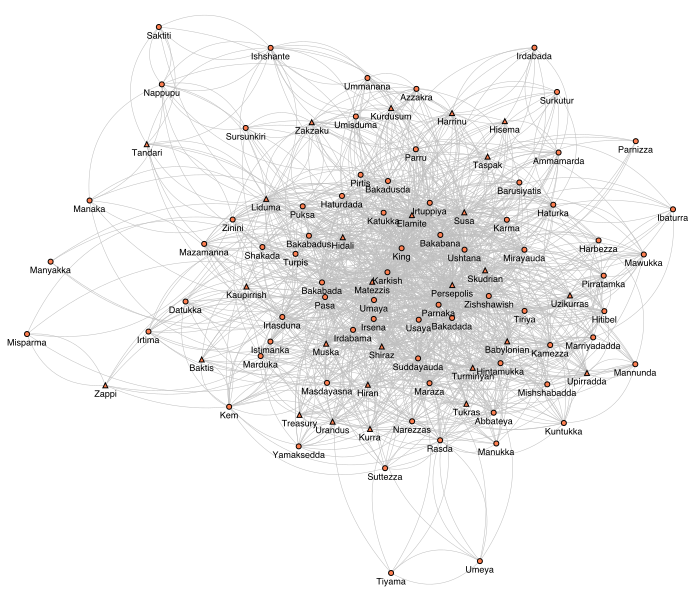

In [66]:
A = M.T @ M
A_degrees = np.diagonal(A).copy()

# Draw the graph; first, remove self loops
np.fill_diagonal(A, 0)
sources, targets = A.nonzero()
edgelist = zip(sources.tolist(), targets.tolist())
g = Graph(A.shape[0], list(edgelist))
g.vs["name"] = ents

# Delete ENs (vertices) with no edges
print("Number of vertices with no, 1 or 2 edges:", len(list(g.vs.select(_degree_in=[0,1,2]))), "\n")
print("Isolated vertices with no, 1 or 2 edges (i.e. a NE that is in a document where no other, 1 or 2 NEs are mentioned):\n",
      [i["name"] for i in g.vs.select(_degree_in=[0,1,2])])
g.vs.select(_degree_in=[0,1,2]).delete()
print(g.summary())
vertex_shapes = []
for e in ents:
    try:
        vertex_shapes.append(label_shape_mapping[list(entity_label_mapping[e])[0]])
    except:
        vertex_shapes.append("circle")
g.vs["shape"] = vertex_shapes

visual_style = {}
visual_style["layout"] = g.layout("fr")
visual_style["vertex_size"] = 5
visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_label_size"] = 9
visual_style["vertex_label_dist"] = 2
visual_style["vertex_color"] = "Coral" #[color_dict[class] for class in g.vs["class"]]
visual_style["edge_color"] = "Grey"
visual_style["edge_width"] = 0.5
visual_style["bbox"] = (700, 600)
visual_style["margin"] = 27
plot(g, **visual_style)

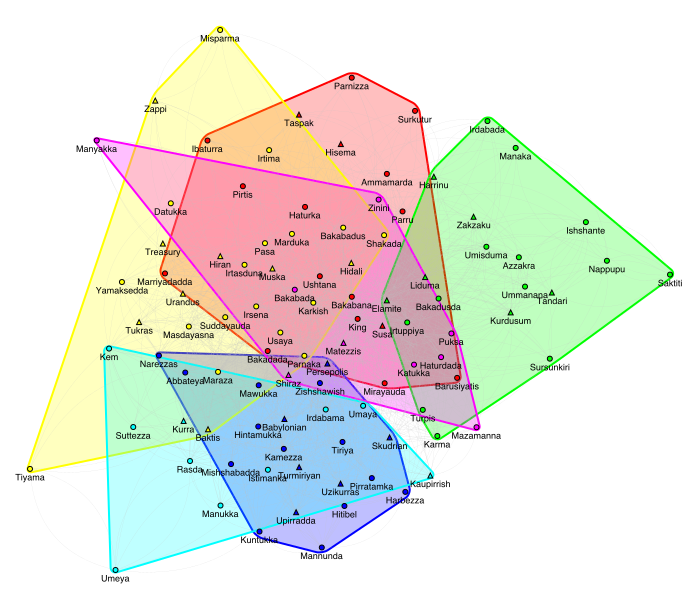

In [68]:
# save your graph in GraphML format and use BioLayout Express 3D 
# g.vs.select(_degree_lt=5).delete()
comms = g.community_multilevel()
# comms = g.community_leading_eigenvector(clusters=K)

visual_style = {}
visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_label_size"] = 9
visual_style["vertex_label_dist"] = 2
visual_style["layout"] = g.layout("fr")
visual_style["vertex_size"] = 5
visual_style["edge_color"] = "Grey"
visual_style["edge_width"] = 0.1
visual_style["bbox"] = (700, 600)
visual_style["margin"] = 30
plot(comms, hovermode='closest', mark_groups=True, **visual_style)


In [69]:
# # Plot the reordered adjacency matrix
# np.fill_diagonal(A, A_degrees)

# membership_cf = np.array(comms.membership)
# classes_cf = np.unique(membership_cf)
# ids_k_cf = {k: list(np.where(membership_cf==k)[0]) for k in classes_cf}
# ranked_clusters_cf = sorted(ids_k_cf, key=lambda k: len(ids_k_cf[k]), reverse=True)

# print("Modularity score:", comms.modularity)
# print("Number of classes:", len(classes_cf))

# ordered_A_cf = reordering_by_clusters(A, ranked_clusters_cf, ids_k_cf)
# ordered_ents_ind_cf = sum(list(map(list, [ids_k_cf[k] for k in ranked_clusters_cf])), [])
# ordered_ents_cf = [ents[i] for i in ordered_ents_ind_cf]

# plt.figure(figsize=(30,22))
# ax = plt.gca()
# im = ax.imshow(ordered_A_cf, origin="lower", vmax=10)
# ax.set_xticks(range(len(ordered_ents_cf)))
# ax.set_xticklabels(ordered_ents_cf, rotation=85, fontsize=13)
# ax.set_yticks(range(len(ordered_ents_cf)))
# ax.set_yticklabels(ordered_ents_cf, fontsize=13)
# plt.xlim([x_min-.5, x_max])
# plt.ylim([x_min-.5, x_max])
# cbar = plt.colorbar(im, pad=0, aspect=30)
# cbar.ax.tick_params(labelsize=12)
# plt.savefig("Community eigenvector_ordered adjacency matrix_{} clusters".format(len(classes_cf)), dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
# plt.show()


Modularity score: 0.24056325011184362
Number of classes: 6


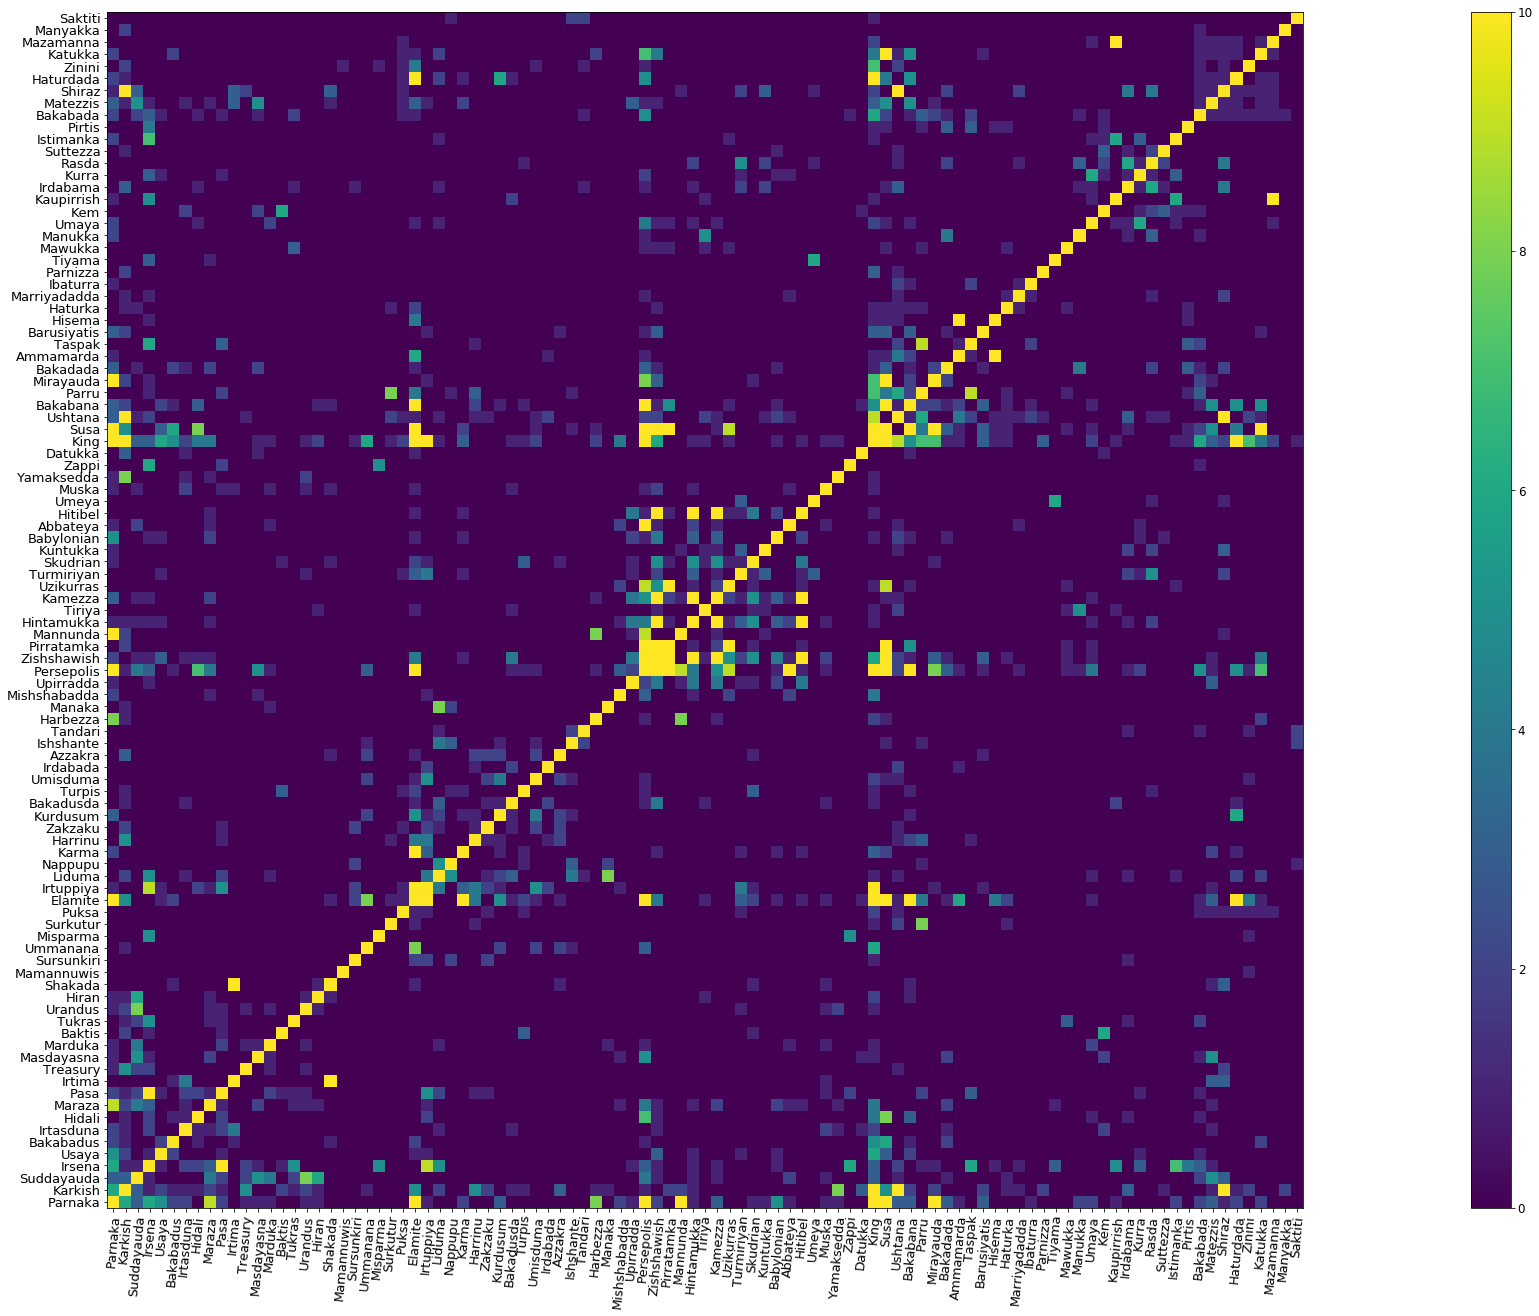

In [70]:
comms = g.community_multilevel()
# Plot the reordered adjacency matrix
np.fill_diagonal(A, A_degrees)

membership_cf = np.array(comms.membership)
classes_cf = np.unique(membership_cf)
ids_k_cf = {k: list(np.where(membership_cf==k)[0]) for k in classes_cf}
ranked_clusters_cf = sorted(ids_k_cf, key=lambda k: len(ids_k_cf[k]), reverse=True)

print("Modularity score:", comms.modularity)
print("Number of classes:", len(classes_cf))

ordered_A_cf = reordering_by_clusters(A, ranked_clusters_cf, ids_k_cf)
ordered_ents_ind_cf = sum(list(map(list, [ids_k_cf[k] for k in ranked_clusters_cf])), [])
ordered_ents_cf = [ents[i] for i in ordered_ents_ind_cf]

plt.figure(figsize=(30,22))
ax = plt.gca()
im = ax.imshow(ordered_A_cf, origin="lower", vmax=10)
ax.set_xticks(range(len(ordered_ents_cf)))
ax.set_xticklabels(ordered_ents_cf, rotation=85, fontsize=13)
ax.set_yticks(range(len(ordered_ents_cf)))
ax.set_yticklabels(ordered_ents_cf, fontsize=13)
cbar = plt.colorbar(im, pad=0.1, aspect=30)
cbar.ax.tick_params(labelsize=12)
plt.savefig("Community multilevel_ordered adjacency matrix_{} clusters".format(len(classes_cf)),
            dpi=1000, facecolor='w', edgecolor='w', bbox_inches="tight", pad_inches=0.1, format="png")
plt.show()

In [78]:
# save your graph in GraphML format and use BioLayout Express 3D 
# g.vs.select(_degree_lt=5).delete()
comms_tree = g.community_edge_betweenness(directed=False)
visual_style = {}
visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_label_size"] = 9
visual_style["vertex_label_dist"] = 2
visual_style["layout"] = g.layout("automatic")
visual_style["vertex_size"] = 5
visual_style["edge_color"] = "Grey"
visual_style["edge_width"] = 0.1
visual_style["bbox"] = (600, 1000)
visual_style["margin"] = 30
plot(comms_tree, hovermode='closest', mark_groups=True, **visual_style)

KeyError: 'Attribute does not exist'

# Sketchbook

/Users/jrun/Library/Python/3.7/lib/python/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


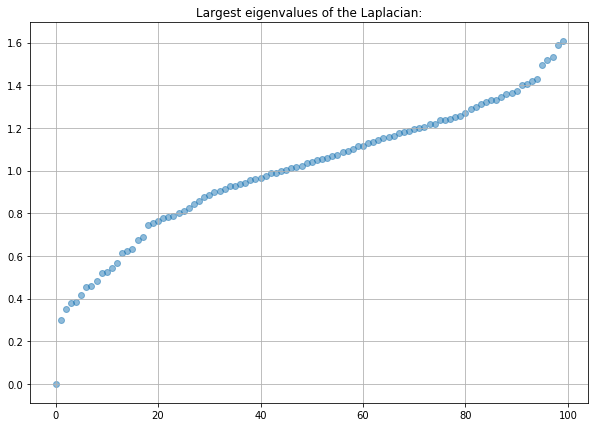

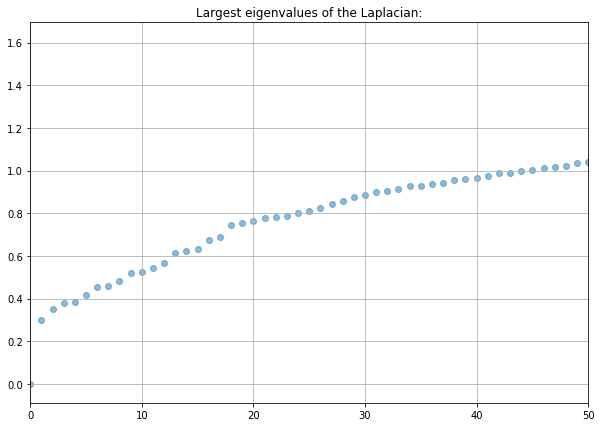

Choices for optimal number of clusters [ 1 95 98 18  2 13 16  9  6  5]


array([1.33226763e-15, 2.98311367e-01, 3.49007807e-01, 3.77393930e-01,
       3.85196595e-01, 4.18757886e-01, 4.53229832e-01, 4.58822461e-01,
       4.81795037e-01, 5.21341629e-01, 5.24680840e-01, 5.43850348e-01,
       5.65275022e-01, 6.15311469e-01, 6.22079814e-01, 6.33745805e-01,
       6.75496898e-01, 6.90105435e-01, 7.43458540e-01, 7.53677019e-01,
       7.62110759e-01, 7.77927670e-01, 7.81928929e-01, 7.87692085e-01,
       8.03050214e-01, 8.11535749e-01, 8.24710458e-01, 8.43144474e-01,
       8.58401391e-01, 8.75991561e-01, 8.86417444e-01, 8.99777233e-01,
       9.05839045e-01, 9.14150375e-01, 9.25279641e-01, 9.29303660e-01,
       9.35208415e-01, 9.39678246e-01, 9.53559579e-01, 9.59844483e-01,
       9.64486051e-01, 9.75305780e-01, 9.87004340e-01, 9.87774023e-01,
       9.97207453e-01, 1.00058995e+00, 1.00975333e+00, 1.01635567e+00,
       1.02338888e+00, 1.03645641e+00, 1.03918197e+00, 1.04714707e+00,
       1.05175708e+00, 1.05965443e+00, 1.06829661e+00, 1.07429597e+00,
      

In [71]:
# Determine the number of clusters automatically

A = M.T @ M
def eigenDecomposition(A, plot=True, topK=20):
    """
    A: Affinity matrix
    plot: plots the sorted eigen values for visual inspection
    This returns a tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigenvalues
    - all eigenvectors
    
    This method performs the eigen decomposition on the adjacency matrix,
    following the steps recommended in the paper:
    1. Construct the normalized adjacency matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigenvectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
   # eigenvalues, eigenvectors = LA.eig(L)
    
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

nb_clusters, eigenvalues, eigenvectors = eigenDecomposition(A, plot=True, topK=10)

plt.figure(figsize=(10, 7))
plt.title('Largest eigenvalues of the Laplacian:')
plt.scatter(np.arange(len(eigenvalues)), eigenvalues, alpha=0.5)
plt.grid()
plt.show()
        
plt.figure(figsize=(10, 7))
plt.title('Largest eigenvalues of the Laplacian:')
plt.scatter(np.arange(len(eigenvalues)), eigenvalues, alpha=0.5)
plt.xlim([0, A.shape[0]/2])
plt.grid()
plt.show()

print("Choices for optimal number of clusters", nb_clusters) # these correspond to eigenvalues with largest gaps/jumps
eigenvalues

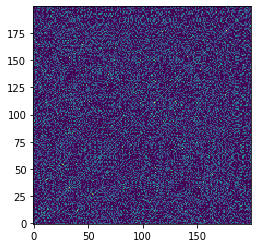

spectral clustering
[3 0 4 4 3 2 0 4 1 2 4 4 1 2 2 4 2 1 1 4 0 3 2 4 1 3 2 4 3 1 1 3 1 0 1 0 1
 0 0 4 1 2 0 1 2 2 4 2 3 4 1 2 3 1 4 4 3 3 1 4 3 3 3 1 0 3 2 3 4 2 3 3 2 3
 0 3 4 2 4 0 1 4 3 1 0 1 4 0 3 1 2 0 4 2 0 4 2 4 0 1 2 2 1 3 3 0 4 0 2 2 0
 0 2 1 1 0 3 1 3 0 2 0 1 4 1 0 0 4 0 3 2 0 4 2 4 4 2 2 3 4 1 4 3 1 3 4 3 0
 4 2 0 2 0 0 3 1 0 4 0 1 1 3 2 1 2 3 4 4 1 0 3 4 0 3 1 4 3 0 1 2 4 4 3 2 1
 0 0 0 0 1 2 2 3 3 1 2 2 1 2 3]


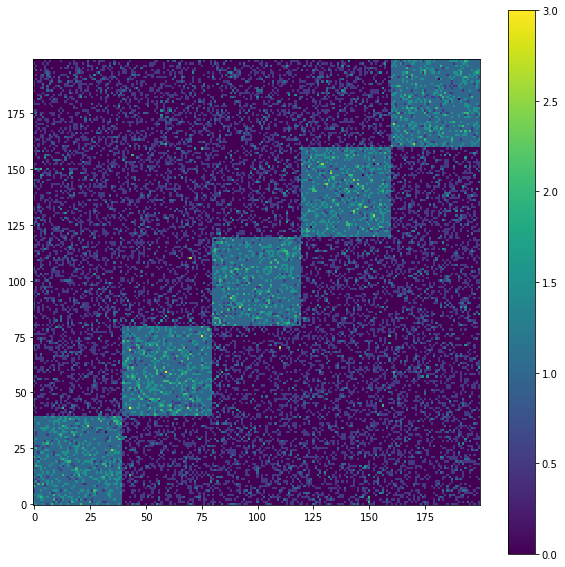

In [72]:
# SIMULATION for spectral clustering
N = 200
shuffled_list = random.sample(range(N), N)
# shuffled_list = range(N)

K = 5
A = np.zeros((N, N))
p_in = 96
p_out = 4
for k in range(K):
    ind_k = [shuffled_list[i_] for i_ in list(range(int(k*N/K), int((k+1)*N/K)))]
    for i in range(N):
        for j in range(N):
            if (i in ind_k and j in ind_k):
                A[i, j] += random.choices([0, 1], weights=[100-p_in, p_in])[0]
            else:
                A[i, j] += random.choices([0, 1], weights=[100-p_out, p_out])[0]
A = (A + A.T)/2.
                
plt.imshow(A, origin="lower")
plt.show()


np.random.seed(0)
sc = SpectralClustering(K, affinity='precomputed', n_init=100)
sc.fit(A)

print('spectral clustering')
print(sc.labels_)

ranked_clusters_sc = [i[0] for i in list(Counter(sc.labels_).most_common())]
ids_k_sc = {k: np.where(sc.labels_==k)[0] for k in range(K)}
ordered_A_sc = reordering_by_clusters(A, ranked_clusters_sc, ids_k_sc)

plt.figure(figsize=(10,10))
plt.imshow(ordered_A_sc, origin="lower")
plt.colorbar()
plt.show()

Modularity score: 0.2195314519946386
Number of classes: 5


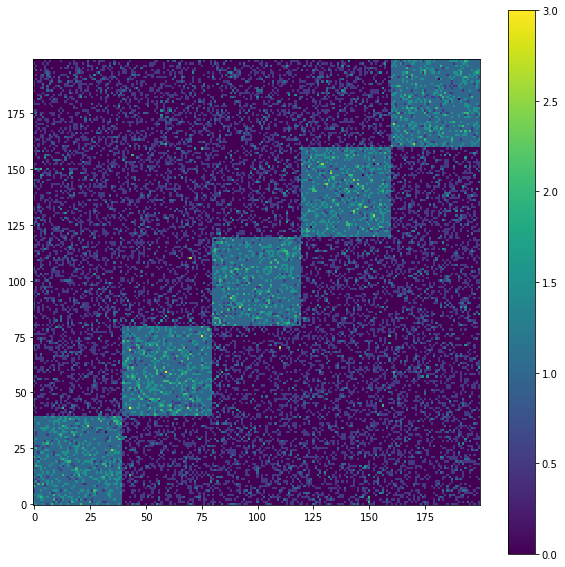

In [73]:
### SIMULATION for community finding
A_degrees = np.diagonal(A).copy()
np.fill_diagonal(A, 0)
sources, targets = A.nonzero()
edgelist = zip(sources.tolist(), targets.tolist())
g = Graph(A.shape[0], list(edgelist))

comms = g.community_multilevel()
# comms = g.community_leading_eigenvector(clusters=K)
# comms = g.community_edge_betweenness(directed=False)

# Plot the reordered adjacency matrix
np.fill_diagonal(A, A_degrees)
membership = np.array(comms.membership)
classes = np.unique(membership)
ids_k_ev = {k: list(np.where(membership==k)[0]) for k in classes}
ranked_clusters_ev = sorted(ids_k_ev, key=lambda k: len(ids_k_ev[k]), reverse=True)
ordered_A_ev = reordering_by_clusters(A, ranked_clusters_ev, ids_k_ev)

print("Modularity score:", comms.modularity)
print("Number of classes:", len(classes))

plt.figure(figsize=(10,10))
plt.imshow(ordered_A_ev, origin="lower")
plt.colorbar()
plt.show()


In [74]:
visual_style = {}
visual_style["layout"] = g.layout("fr")
visual_style["vertex_size"] = 5
visual_style["edge_color"] = "Grey"
visual_style["edge_width"] = 0.1
plot(comms, hovermode='closest', mark_groups=True, **visual_style)
